# Flight Delay Prediction - Exploratory Data Analysis


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import warnings
import random
from io import StringIO

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## Feature Selection Rationale

### Features We Rule Out

We exclude most features from the dataset for several key reasons:

- **Redundant features**: Temporal components (Year, Quarter, Month, DayOfWeek) can be derived from `FlightDate`; geographic identifiers have multiple representations (AirportID vs AirportSeqID, State vs StateFips) where one suffices; delay metrics have overlapping versions (DepDelay vs DepDelayMinutes, DepDel15 as binary indicator).

- **Data leakage risk**: Delay cause breakdowns (`CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay`) are post-hoc categorizations unavailable at prediction time. **Note**: While we exclude these from the prediction model, we can recover them later to validate our explainability (comparing model predictions against actual delay causes to ensure the model's reasoning aligns with ground truth).

- **Too specific or rare**: Diversion details (Div1Airport through Div5Airport) apply to <1% of flights; aircraft-level features (`Tail_Number`) are too granular and risk overfitting; code-share complexities add minimal predictive value.

- **Different purposes**: `Flights` is an aggregation count; `Duplicate` is a data quality flag; elapsed time metrics are less directly related to delays than delay minutes themselves.

### Why Selected Features Are Sufficient

The selected features provide sufficient information for delay prediction by capturing essential dimensions:

- **Temporal patterns**: `FlightDate` and scheduled times (`CRSDepTime`, `CRSArrTime`) capture time-of-day and seasonal effects
- **Airline and route characteristics**: `Airline`, `Flight_Number_Marketing_Airline`, and origin/destination identifiers capture carrier-specific and route-specific patterns
- **Geographic context**: Airport IDs and city/state names enable modeling of weather patterns, regional congestion, and regulatory differences
- **Operational factors**: `TaxiOut` and `TaxiIn` directly impact delays and indicate ground congestion
- **Status indicators**: `Cancelled` and `Diverted` capture extreme operational disruptions

This feature set balances predictive power with practical feasibility—all features are available at prediction time, avoid redundancy, and maintain interpretability for explainability analysis.

In [2]:
# Feel free de modificar el subset si creus q s'ha d'afegir o sobra algo
column_subset = [
    "FlightDate",
    "Airline",
    "Flight_Number_Marketing_Airline",
    "Origin",
    "Dest",
    "Cancelled",
    "Diverted",
    "CRSDepTime",
    "DepTime",
    "DepDelayMinutes",
    "OriginAirportID",
    "OriginCityName",
    "OriginStateName",
    "DestAirportID",
    "DestCityName",
    "DestStateName",
    "TaxiOut",
    "TaxiIn",
    "CRSArrTime",
    "ArrTime",
    "ArrDelayMinutes",
    "Distance"
]

max_rows_per_file = 100000  # We limit the number of rows to avoid memory issues


def reservoir_sample_csv(file_path, k, random_state=42):
    """Memory-efficient random sampling of up to k rows from a large CSV using reservoir sampling."""
    random.seed(random_state)
    sample_lines = []
    with open(file_path, 'r', encoding='utf-8') as f:
        header = f.readline()
        for i, line in enumerate(f):
            if i < k:
                sample_lines.append(line)
            else:
                j = random.randint(0, i)
                if j < k:
                    sample_lines[j] = line
    # Build a mini CSV in memory and read it with pandas
    csv_buffer = StringIO(header + ''.join(sample_lines))
    return pd.read_csv(csv_buffer)


data_dir = 'data'
dfs = []
for filename in os.listdir(data_dir):
    file_path = os.path.join(data_dir, filename)
    if filename.endswith('.csv'):
        # Reservoir sampling preserves data distribution without loading the full file in memory
        df_temp = reservoir_sample_csv(file_path, max_rows_per_file, random_state=42)
        dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True)


## Target Variable Exploration: Flight Delays


In [3]:
# Basic dataset info and delay overview
print("Dataset Shape:", df.shape)
print("\nMissing Values:")
print(df[['DepDelayMinutes', 'ArrDelayMinutes', 'Cancelled', 'Diverted']].isnull().sum())
print("\nBasic Statistics for Delays:")
print(df[['DepDelayMinutes', 'ArrDelayMinutes']].describe())
print("\nCancellation Rate:", df['Cancelled'].mean() * 100, "%")
print("Diversion Rate:", df['Diverted'].mean() * 100, "%")


Dataset Shape: (500000, 61)

Missing Values:
DepDelayMinutes    13822
ArrDelayMinutes    15226
Cancelled              0
Diverted               0
dtype: int64

Basic Statistics for Delays:
       DepDelayMinutes  ArrDelayMinutes
count    486178.000000    484774.000000
mean         12.706550        12.723486
std          46.511738        46.010063
min           0.000000         0.000000
25%           0.000000         0.000000
50%           0.000000         0.000000
75%           5.000000         6.000000
max        2102.000000      2108.000000

Cancellation Rate: 2.8148 %
Diversion Rate: 0.22859999999999997 %


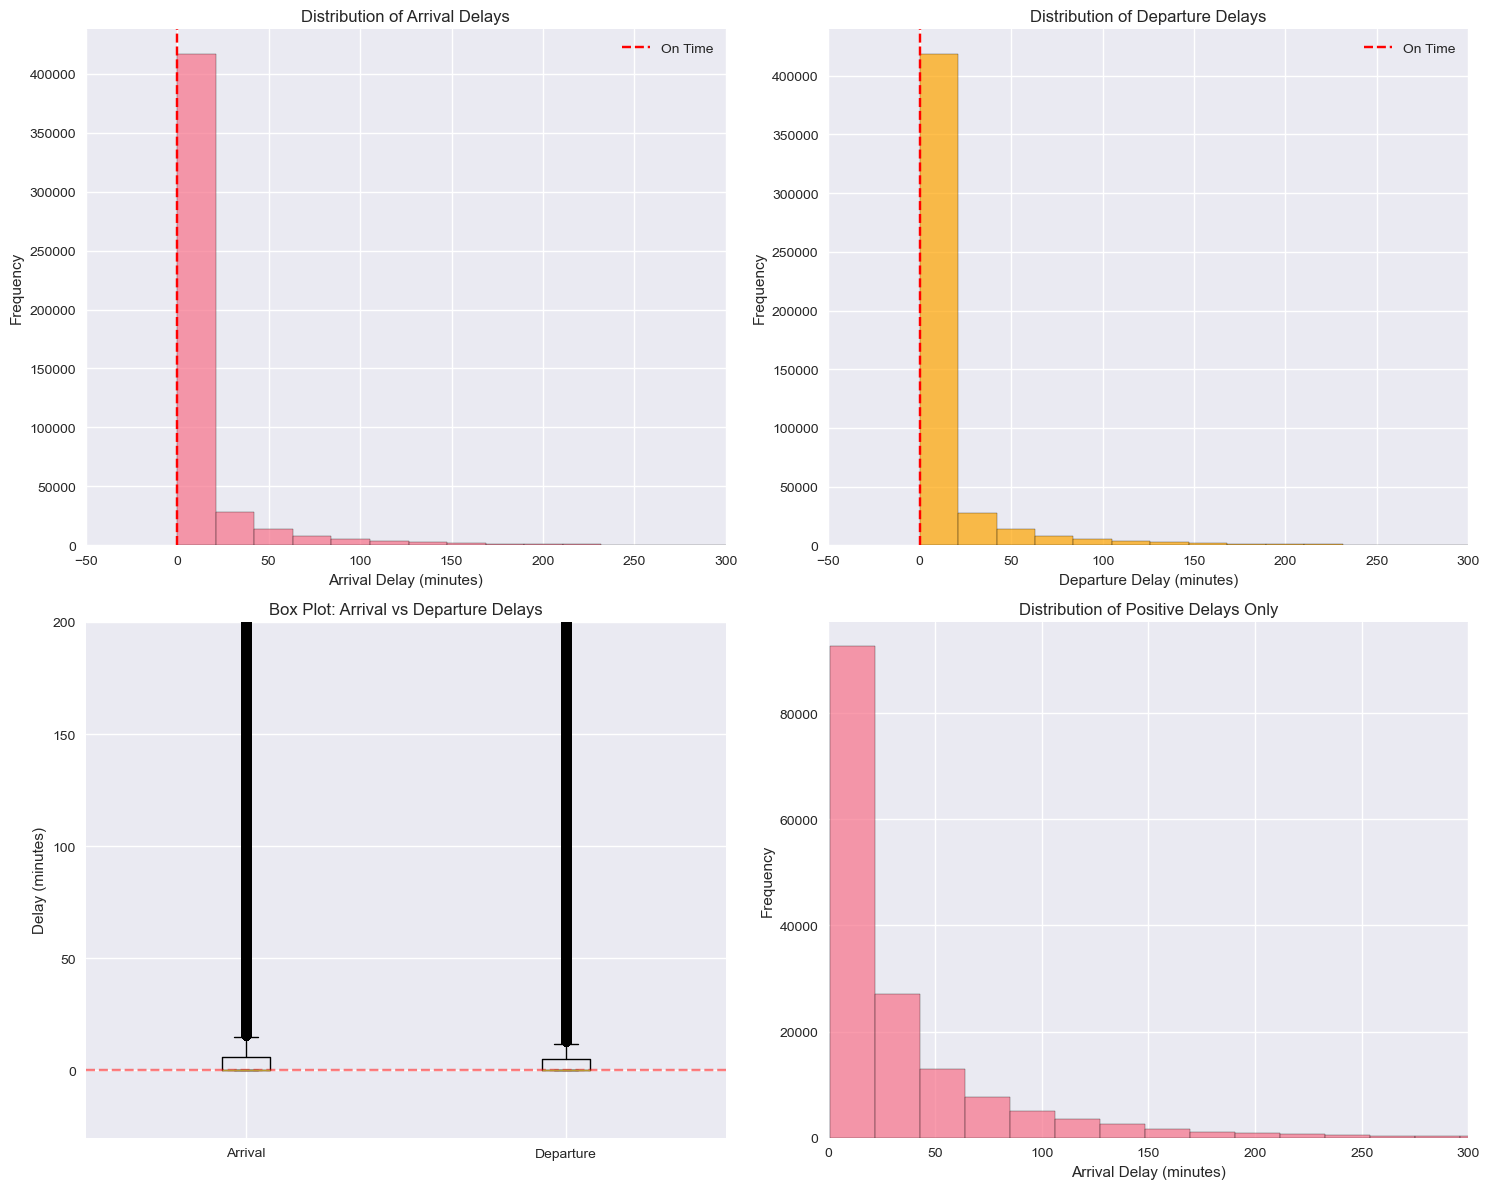


Delay Percentiles:
Arrival Delays:
0.10      0.0
0.25      0.0
0.50      0.0
0.75      6.0
0.90     34.0
0.95     69.0
0.99    182.0
Name: ArrDelayMinutes, dtype: float64

Departure Delays:
0.10      0.0
0.25      0.0
0.50      0.0
0.75      5.0
0.90     34.0
0.95     69.0
0.99    185.0
Name: DepDelayMinutes, dtype: float64


In [4]:
# Delay Distribution Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Arrival Delay Distribution (histogram)
axes[0, 0].hist(df['ArrDelayMinutes'].dropna(), bins=100, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Arrival Delay (minutes)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Arrival Delays')
axes[0, 0].axvline(x=0, color='red', linestyle='--', label='On Time')
axes[0, 0].legend()
axes[0, 0].set_xlim(-50, 300)  # Focus on most common delays

# Departure Delay Distribution (histogram)
axes[0, 1].hist(df['DepDelayMinutes'].dropna(), bins=100, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Departure Delay (minutes)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Departure Delays')
axes[0, 1].axvline(x=0, color='red', linestyle='--', label='On Time')
axes[0, 1].legend()
axes[0, 1].set_xlim(-50, 300)

# Box plots for both delays
delay_data = [df['ArrDelayMinutes'].dropna(), df['DepDelayMinutes'].dropna()]
axes[1, 0].boxplot(delay_data, labels=['Arrival', 'Departure'], vert=True)
axes[1, 0].set_ylabel('Delay (minutes)')
axes[1, 0].set_title('Box Plot: Arrival vs Departure Delays')
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].set_ylim(-30, 200)

# Log scale distribution (to see tail better)
arr_delays_positive = df[df['ArrDelayMinutes'] > 0]['ArrDelayMinutes']
axes[1, 1].hist(arr_delays_positive, bins=100, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Arrival Delay (minutes)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Positive Delays Only')
axes[1, 1].set_xlim(0, 300)

plt.tight_layout()
plt.show()

# Percentiles
print("\nDelay Percentiles:")
print("Arrival Delays:")
print(df['ArrDelayMinutes'].quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
print("\nDeparture Delays:")
print(df['DepDelayMinutes'].quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))


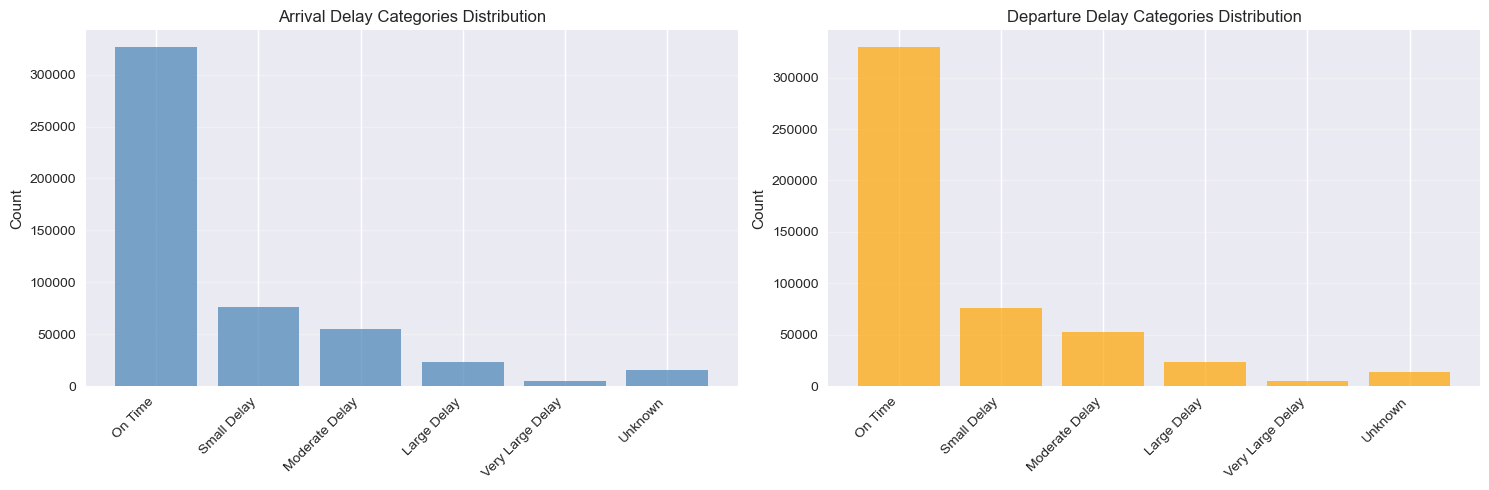


Arrival Delay Category Percentages:
ArrDelayCategory
On Time             65.25
Small Delay         15.18
Moderate Delay      10.97
Large Delay          4.58
Very Large Delay     0.99
Unknown              3.05
Name: count, dtype: float64

Departure Delay Category Percentages:
DepDelayCategory
On Time             65.87
Small Delay         15.12
Moderate Delay      10.58
Large Delay          4.65
Very Large Delay     1.02
Unknown              2.76
Name: count, dtype: float64


In [5]:
# Create delay categories (binning)
def categorize_delay(delay_minutes):
    """Categorize delays into meaningful bins"""
    if pd.isna(delay_minutes):
        return 'Unknown'
    elif delay_minutes < 0:
        return 'Early'
    elif delay_minutes == 0:
        return 'On Time'
    elif delay_minutes <= 15:
        return 'Small Delay'
    elif delay_minutes <= 60:
        return 'Moderate Delay'
    elif delay_minutes <= 180:
        return 'Large Delay'
    else:
        return 'Very Large Delay'

df['ArrDelayCategory'] = df['ArrDelayMinutes'].apply(categorize_delay)
df['DepDelayCategory'] = df['DepDelayMinutes'].apply(categorize_delay)

# Distribution of delay categories
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

arr_cat_counts = df['ArrDelayCategory'].value_counts()
dep_cat_counts = df['DepDelayCategory'].value_counts()

# Order categories logically
category_order = ['Early', 'On Time', 'Small Delay', 'Moderate Delay', 'Large Delay', 'Very Large Delay', 'Unknown']
arr_cat_counts = arr_cat_counts.reindex([c for c in category_order if c in arr_cat_counts.index])
dep_cat_counts = dep_cat_counts.reindex([c for c in category_order if c in dep_cat_counts.index])

axes[0].bar(range(len(arr_cat_counts)), arr_cat_counts.values, color='steelblue', alpha=0.7)
axes[0].set_xticks(range(len(arr_cat_counts)))
axes[0].set_xticklabels(arr_cat_counts.index, rotation=45, ha='right')
axes[0].set_ylabel('Count')
axes[0].set_title('Arrival Delay Categories Distribution')
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(range(len(dep_cat_counts)), dep_cat_counts.values, color='orange', alpha=0.7)
axes[1].set_xticks(range(len(dep_cat_counts)))
axes[1].set_xticklabels(dep_cat_counts.index, rotation=45, ha='right')
axes[1].set_ylabel('Count')
axes[1].set_title('Departure Delay Categories Distribution')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Percentage breakdown
print("\nArrival Delay Category Percentages:")
print((arr_cat_counts / len(df) * 100).round(2))
print("\nDeparture Delay Category Percentages:")
print((dep_cat_counts / len(df) * 100).round(2))


In [6]:
# Prepare temporal features
df['FlightDate'] = pd.to_datetime(df['FlightDate'])
df['DayOfWeek'] = df['FlightDate'].dt.day_name()
df['Month'] = df['FlightDate'].dt.month_name()
df['Year'] = df['FlightDate'].dt.year

# Extract hour from CRSDepTime (format: HHMM as integer)
df['DepHour'] = (df['CRSDepTime'] // 100).astype(int)
df['DepTimeOfDay'] = pd.cut(df['DepHour'], 
                                     bins=[0, 6, 12, 18, 24], 
                                     labels=['Night (0-6)', 'Morning (6-12)', 'Afternoon (12-18)', 'Evening (18-24)'],
                                     include_lowest=True)

print("Temporal features created successfully!")
print(f"Date range: {df['FlightDate'].min()} to {df['FlightDate'].max()}")
print(f"Unique airlines: {df['Airline'].nunique()}")
print(f"Unique routes: {df.groupby(['Origin', 'Dest']).ngroups}")


Temporal features created successfully!
Date range: 2018-01-01 00:00:00 to 2022-07-31 00:00:00
Unique airlines: 28
Unique routes: 7459


Airlines by Average Arrival Delay (worst to best):
                                           Avg_ArrDelay  Median_ArrDelay  \
Airline                                                                    
Peninsula Airways Inc.                            34.97             10.0   
Commutair Aka Champlain Enterprises, Inc.         23.63              0.0   
Trans States Airlines                             23.31              0.0   
JetBlue Airways                                   20.22              0.0   
ExpressJet Airlines Inc.                          19.09              0.0   
Allegiant Air                                     18.77              0.0   
GoJet Airlines, LLC d/b/a United Express          17.43              0.0   
Frontier Airlines Inc.                            17.01              0.0   
Air Wisconsin Airlines Corp                       16.38              0.0   
Mesa Airlines Inc.                                15.79              0.0   
American Airlines Inc.               

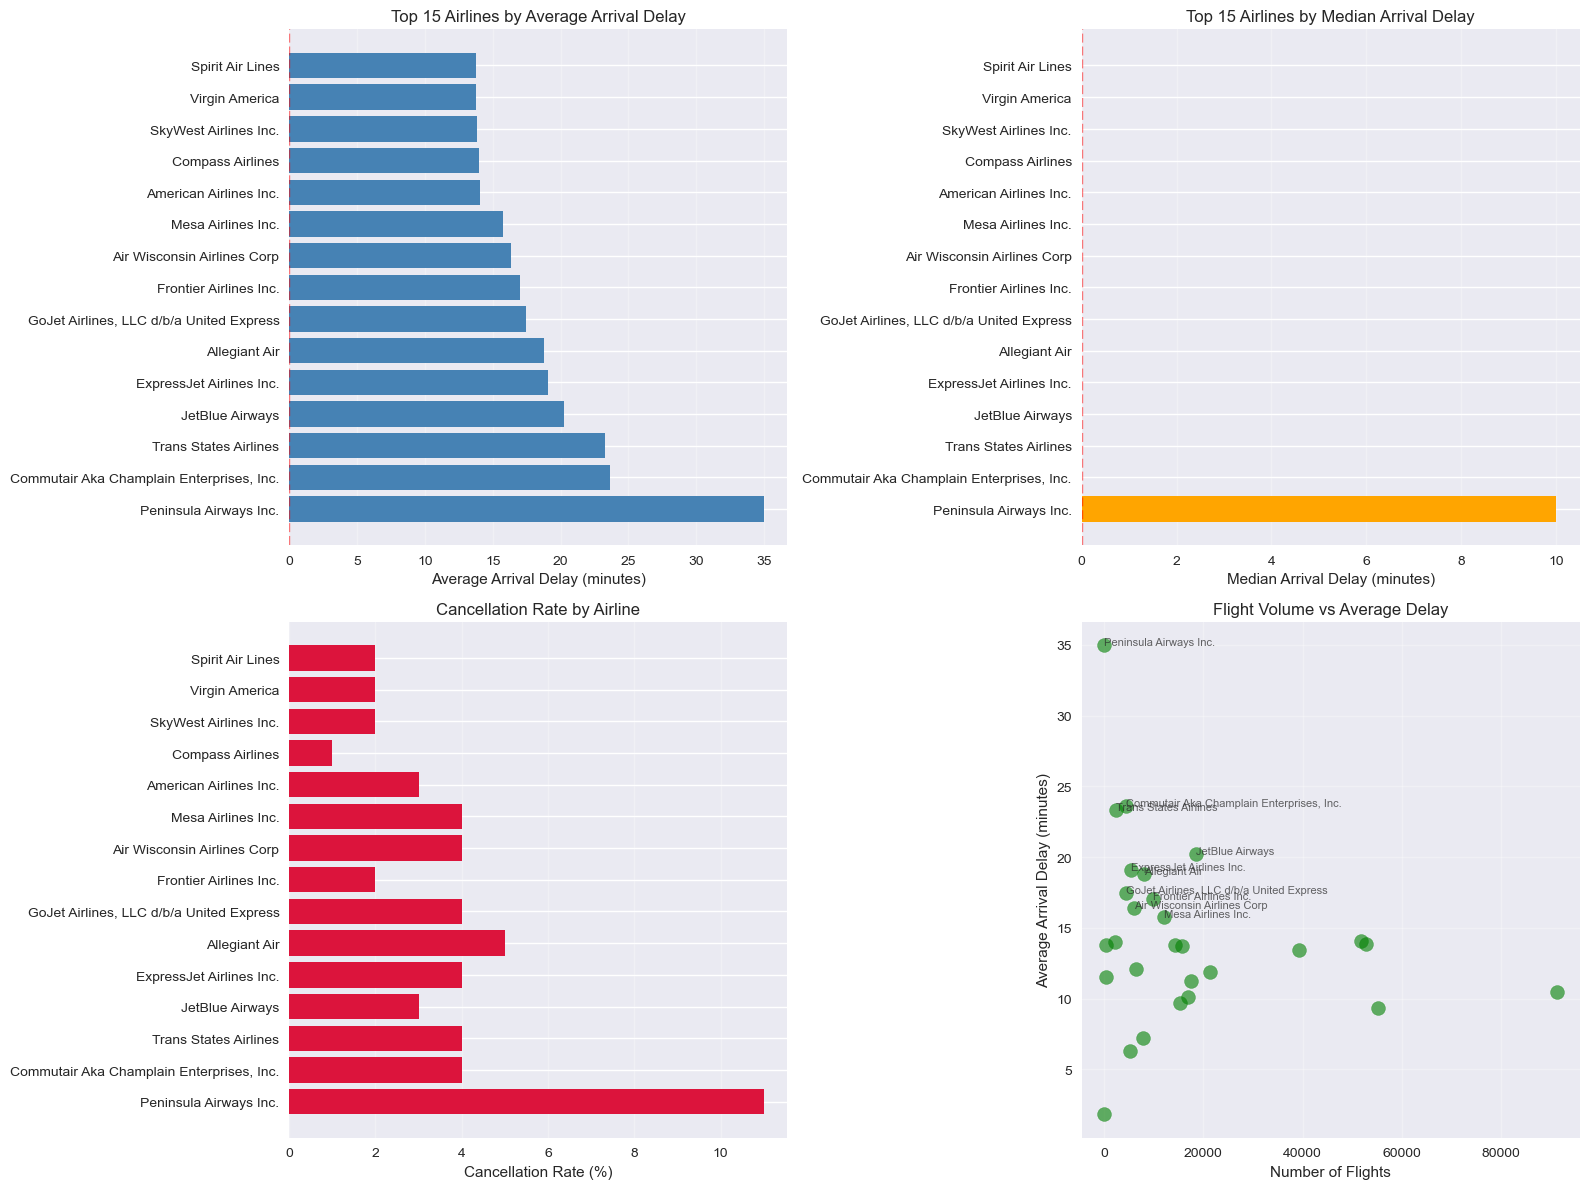

In [7]:
# Airlines by Delay Rate
airline_delays = df.groupby('Airline').agg({
    'ArrDelayMinutes': ['mean', 'median', 'count'],
    'DepDelayMinutes': ['mean', 'median'],
    'Cancelled': 'mean',
    'Diverted': 'mean'
}).round(2)

airline_delays.columns = ['Avg_ArrDelay', 'Median_ArrDelay', 'Flight_Count', 
                          'Avg_DepDelay', 'Median_DepDelay', 'Cancel_Rate', 'Diversion_Rate']
airline_delays = airline_delays.sort_values('Avg_ArrDelay', ascending=False)

print("Airlines by Average Arrival Delay (worst to best):")
print(airline_delays)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Average delay by airline
top_airlines = airline_delays.head(15)
axes[0, 0].barh(range(len(top_airlines)), top_airlines['Avg_ArrDelay'], color='steelblue')
axes[0, 0].set_yticks(range(len(top_airlines)))
axes[0, 0].set_yticklabels(top_airlines.index)
axes[0, 0].set_xlabel('Average Arrival Delay (minutes)')
axes[0, 0].set_title('Top 15 Airlines by Average Arrival Delay')
axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[0, 0].grid(axis='x', alpha=0.3)

# Median delay by airline
axes[0, 1].barh(range(len(top_airlines)), top_airlines['Median_ArrDelay'], color='orange')
axes[0, 1].set_yticks(range(len(top_airlines)))
axes[0, 1].set_yticklabels(top_airlines.index)
axes[0, 1].set_xlabel('Median Arrival Delay (minutes)')
axes[0, 1].set_title('Top 15 Airlines by Median Arrival Delay')
axes[0, 1].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[0, 1].grid(axis='x', alpha=0.3)

# Cancellation rate by airline
axes[1, 0].barh(range(len(top_airlines)), top_airlines['Cancel_Rate'] * 100, color='crimson')
axes[1, 0].set_yticks(range(len(top_airlines)))
axes[1, 0].set_yticklabels(top_airlines.index)
axes[1, 0].set_xlabel('Cancellation Rate (%)')
axes[1, 0].set_title('Cancellation Rate by Airline')
axes[1, 0].grid(axis='x', alpha=0.3)

# Flight count vs delay (scatter)
axes[1, 1].scatter(airline_delays['Flight_Count'], airline_delays['Avg_ArrDelay'], 
                   s=100, alpha=0.6, color='green')
axes[1, 1].set_xlabel('Number of Flights')
axes[1, 1].set_ylabel('Average Arrival Delay (minutes)')
axes[1, 1].set_title('Flight Volume vs Average Delay')
axes[1, 1].grid(alpha=0.3)
# Add airline labels for top delays
for idx, row in airline_delays.head(10).iterrows():
    axes[1, 1].annotate(idx, (row['Flight_Count'], row['Avg_ArrDelay']), 
                        fontsize=8, alpha=0.7)

plt.tight_layout()
plt.show()


Weekdays by Average Arrival Delay:
           Avg_ArrDelay  Median_ArrDelay  Flight_Count  Avg_DepDelay  \
DayOfWeek                                                              
Monday            13.06              0.0         72380         13.09   
Tuesday           11.41              0.0         67428         11.43   
Wednesday         11.37              0.0         68832         11.18   
Thursday          13.62              0.0         71654         13.40   
Friday            14.02              0.0         71879         13.89   
Saturday          12.21              0.0         62131         12.48   
Sunday            13.16              0.0         70470         13.31   

           Median_DepDelay  Cancel_Rate  Diversion_Rate  
DayOfWeek                                                
Monday                 0.0         0.03             0.0  
Tuesday                0.0         0.02             0.0  
Wednesday              0.0         0.03             0.0  
Thursday               0.0

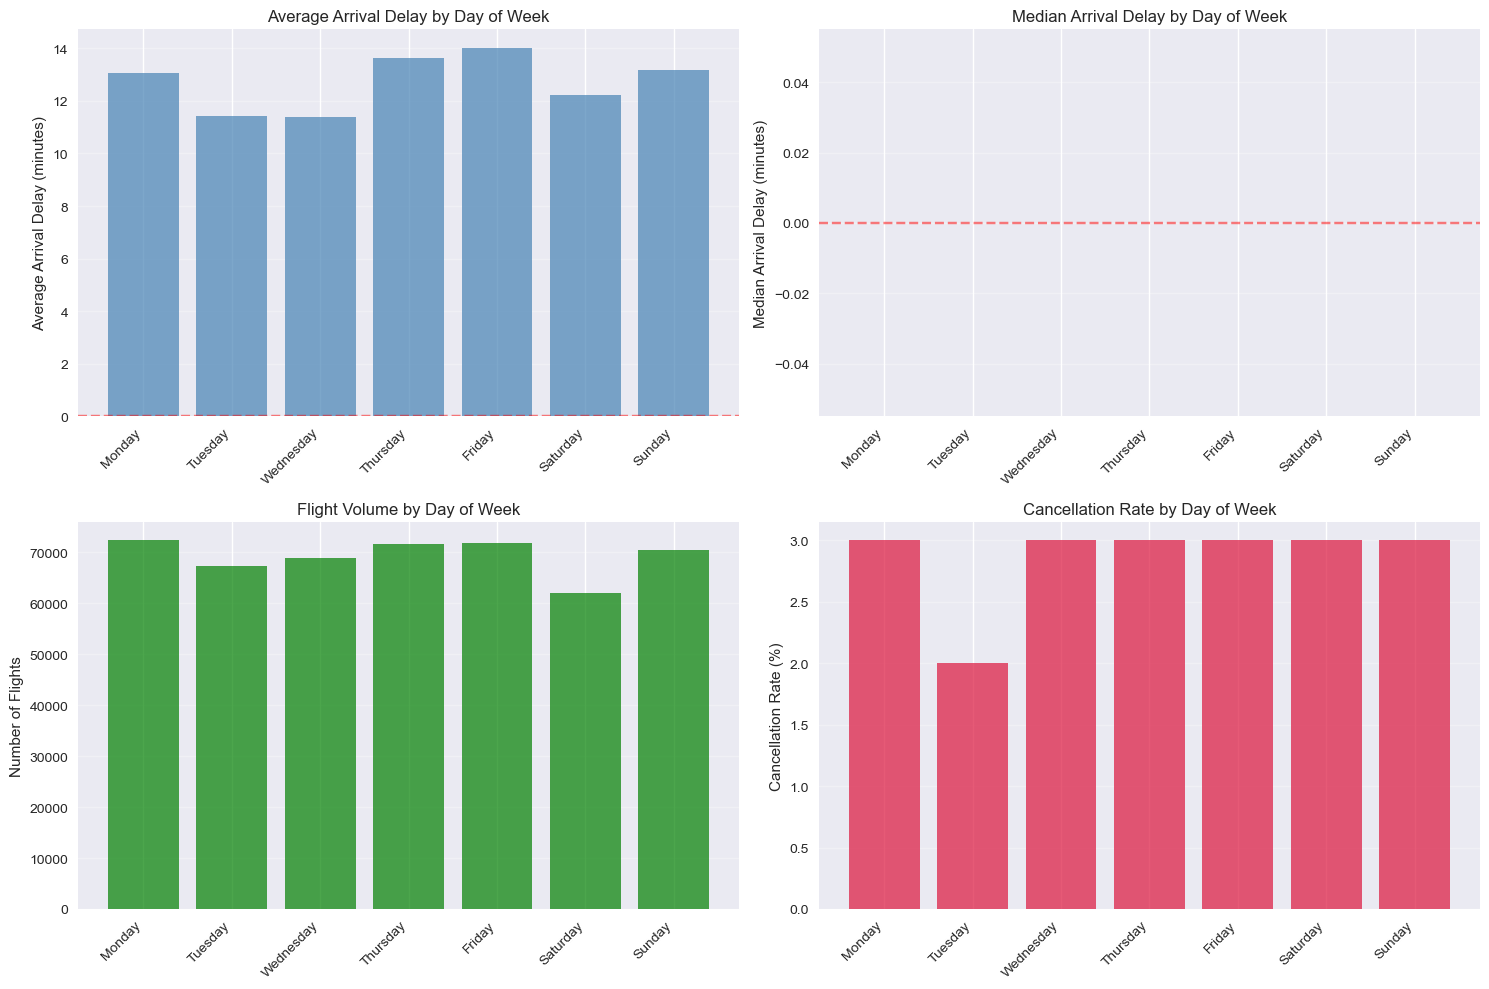

In [8]:
# Weekdays by Delay Rate
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_delays = df.groupby('DayOfWeek').agg({
    'ArrDelayMinutes': ['mean', 'median', 'count'],
    'DepDelayMinutes': ['mean', 'median'],
    'Cancelled': 'mean',
    'Diverted': 'mean'
}).round(2)

weekday_delays.columns = ['Avg_ArrDelay', 'Median_ArrDelay', 'Flight_Count', 
                          'Avg_DepDelay', 'Median_DepDelay', 'Cancel_Rate', 'Diversion_Rate']
weekday_delays = weekday_delays.reindex([day for day in weekday_order if day in weekday_delays.index])

print("Weekdays by Average Arrival Delay:")
print(weekday_delays)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Average delay by weekday
axes[0, 0].bar(range(len(weekday_delays)), weekday_delays['Avg_ArrDelay'], 
               color='steelblue', alpha=0.7)
axes[0, 0].set_xticks(range(len(weekday_delays)))
axes[0, 0].set_xticklabels(weekday_delays.index, rotation=45, ha='right')
axes[0, 0].set_ylabel('Average Arrival Delay (minutes)')
axes[0, 0].set_title('Average Arrival Delay by Day of Week')
axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0, 0].grid(axis='y', alpha=0.3)

# Median delay by weekday
axes[0, 1].bar(range(len(weekday_delays)), weekday_delays['Median_ArrDelay'], 
               color='orange', alpha=0.7)
axes[0, 1].set_xticks(range(len(weekday_delays)))
axes[0, 1].set_xticklabels(weekday_delays.index, rotation=45, ha='right')
axes[0, 1].set_ylabel('Median Arrival Delay (minutes)')
axes[0, 1].set_title('Median Arrival Delay by Day of Week')
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0, 1].grid(axis='y', alpha=0.3)

# Flight count by weekday
axes[1, 0].bar(range(len(weekday_delays)), weekday_delays['Flight_Count'], 
               color='green', alpha=0.7)
axes[1, 0].set_xticks(range(len(weekday_delays)))
axes[1, 0].set_xticklabels(weekday_delays.index, rotation=45, ha='right')
axes[1, 0].set_ylabel('Number of Flights')
axes[1, 0].set_title('Flight Volume by Day of Week')
axes[1, 0].grid(axis='y', alpha=0.3)

# Cancellation rate by weekday
axes[1, 1].bar(range(len(weekday_delays)), weekday_delays['Cancel_Rate'] * 100, 
               color='crimson', alpha=0.7)
axes[1, 1].set_xticks(range(len(weekday_delays)))
axes[1, 1].set_xticklabels(weekday_delays.index, rotation=45, ha='right')
axes[1, 1].set_ylabel('Cancellation Rate (%)')
axes[1, 1].set_title('Cancellation Rate by Day of Week')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


Time of Day by Average Arrival Delay:
                   Avg_ArrDelay  Median_ArrDelay  Flight_Count  Avg_DepDelay  \
DepTimeOfDay                                                                   
Night (0-6)                7.91              0.0         44982          7.29   
Morning (6-12)             9.83              0.0        188095          9.50   
Afternoon (12-18)         15.18              0.0        176210         15.20   
Evening (18-24)           17.07              0.0         75487         18.09   

                   Median_DepDelay  Cancel_Rate  Diversion_Rate  
DepTimeOfDay                                                     
Night (0-6)                    0.0         0.03             0.0  
Morning (6-12)                 0.0         0.03             0.0  
Afternoon (12-18)              0.0         0.03             0.0  
Evening (18-24)                0.0         0.03             0.0  


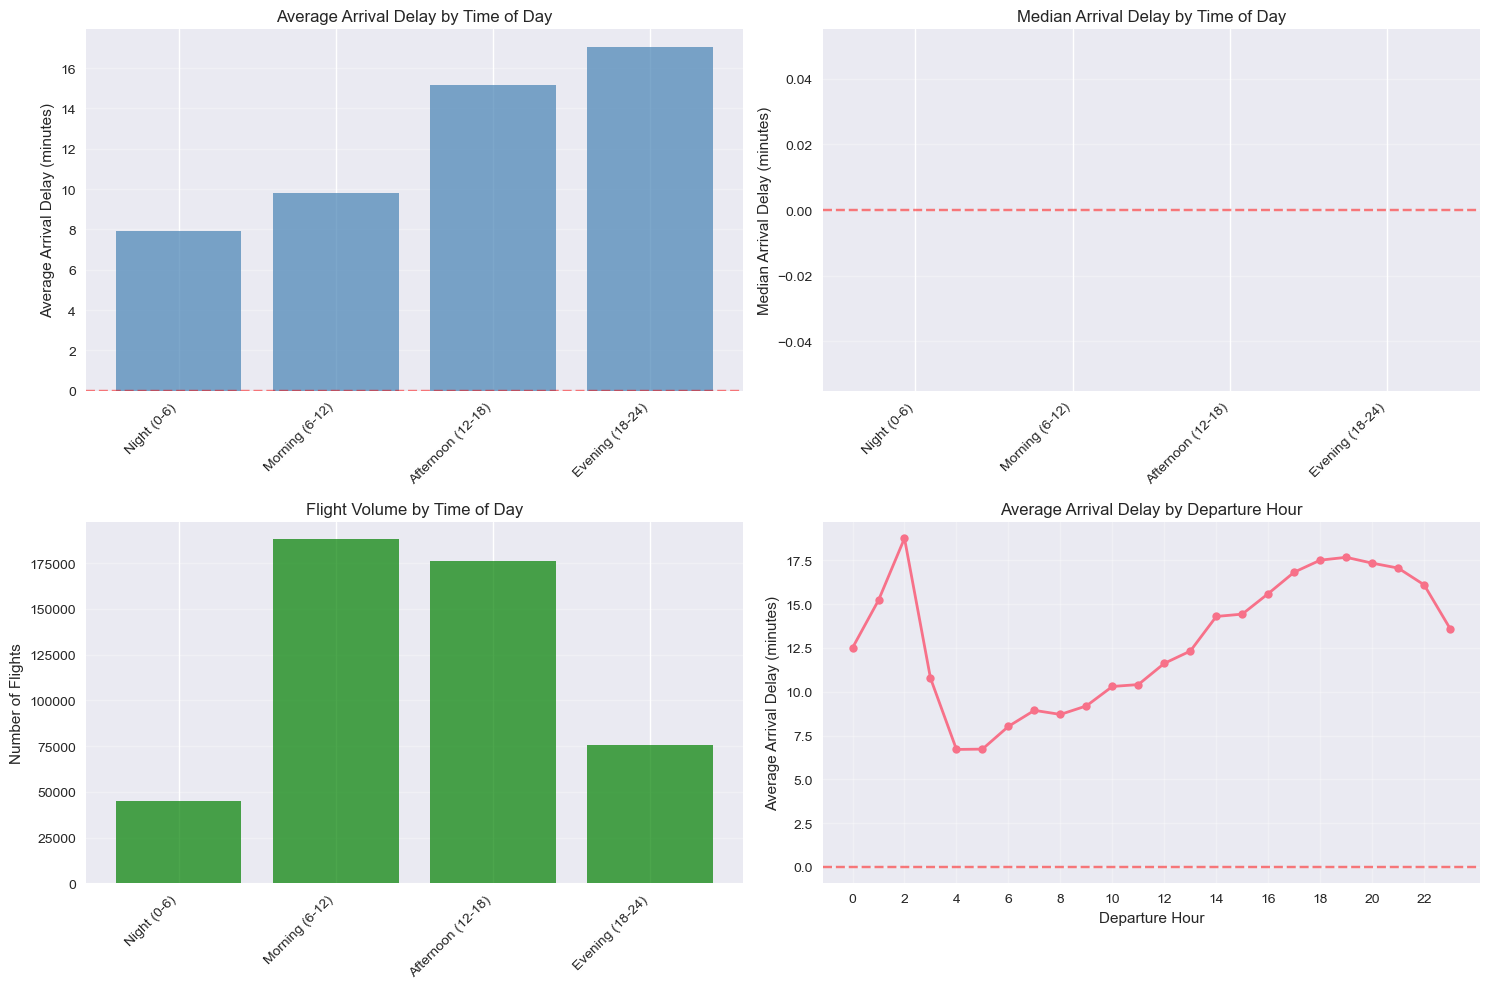

In [9]:
# Time of Day by Delay Rate
time_delays = df.groupby('DepTimeOfDay').agg({
    'ArrDelayMinutes': ['mean', 'median', 'count'],
    'DepDelayMinutes': ['mean', 'median'],
    'Cancelled': 'mean',
    'Diverted': 'mean'
}).round(2)

time_delays.columns = ['Avg_ArrDelay', 'Median_ArrDelay', 'Flight_Count', 
                      'Avg_DepDelay', 'Median_DepDelay', 'Cancel_Rate', 'Diversion_Rate']
time_order = ['Night (0-6)', 'Morning (6-12)', 'Afternoon (12-18)', 'Evening (18-24)']
time_delays = time_delays.reindex([t for t in time_order if t in time_delays.index])

print("Time of Day by Average Arrival Delay:")
print(time_delays)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Average delay by time of day
axes[0, 0].bar(range(len(time_delays)), time_delays['Avg_ArrDelay'], 
               color='steelblue', alpha=0.7)
axes[0, 0].set_xticks(range(len(time_delays)))
axes[0, 0].set_xticklabels(time_delays.index, rotation=45, ha='right')
axes[0, 0].set_ylabel('Average Arrival Delay (minutes)')
axes[0, 0].set_title('Average Arrival Delay by Time of Day')
axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0, 0].grid(axis='y', alpha=0.3)

# Median delay by time of day
axes[0, 1].bar(range(len(time_delays)), time_delays['Median_ArrDelay'], 
               color='orange', alpha=0.7)
axes[0, 1].set_xticks(range(len(time_delays)))
axes[0, 1].set_xticklabels(time_delays.index, rotation=45, ha='right')
axes[0, 1].set_ylabel('Median Arrival Delay (minutes)')
axes[0, 1].set_title('Median Arrival Delay by Time of Day')
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0, 1].grid(axis='y', alpha=0.3)

# Flight count by time of day
axes[1, 0].bar(range(len(time_delays)), time_delays['Flight_Count'], 
               color='green', alpha=0.7)
axes[1, 0].set_xticks(range(len(time_delays)))
axes[1, 0].set_xticklabels(time_delays.index, rotation=45, ha='right')
axes[1, 0].set_ylabel('Number of Flights')
axes[1, 0].set_title('Flight Volume by Time of Day')
axes[1, 0].grid(axis='y', alpha=0.3)

# Delay by hour (more granular)
hour_delays = df.groupby('DepHour')['ArrDelayMinutes'].mean().sort_index()
axes[1, 1].plot(hour_delays.index, hour_delays.values, marker='o', linewidth=2, markersize=6)
axes[1, 1].set_xlabel('Departure Hour')
axes[1, 1].set_ylabel('Average Arrival Delay (minutes)')
axes[1, 1].set_title('Average Arrival Delay by Departure Hour')
axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1, 1].grid(alpha=0.3)
axes[1, 1].set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()


ADDITIONAL DELAY INSIGHTS

On-Time Performance (≤15 min delay): 80.42%
Early Arrivals Rate: 0.00%

Cancelled Flights: 14,074 (2.81%)
Diverted Flights: 1,143 (0.23%)

Monthly Delay Patterns:
           Avg_ArrDelay  Median_ArrDelay  Flight_Count  Cancel_Rate
Month                                                              
January           12.01              0.0         47465         0.03
February          13.48              0.0         41636         0.03
March             10.88              0.0         47702         0.06
April             12.50              0.0         41291         0.08
May               12.87              0.0         40625         0.02
June              16.23              0.0         41830         0.02
July              16.02              0.0         46779         0.02
August            14.34              0.0         34181         0.02
September          9.84              0.0         34560         0.01
October           10.39              0.0         36691        

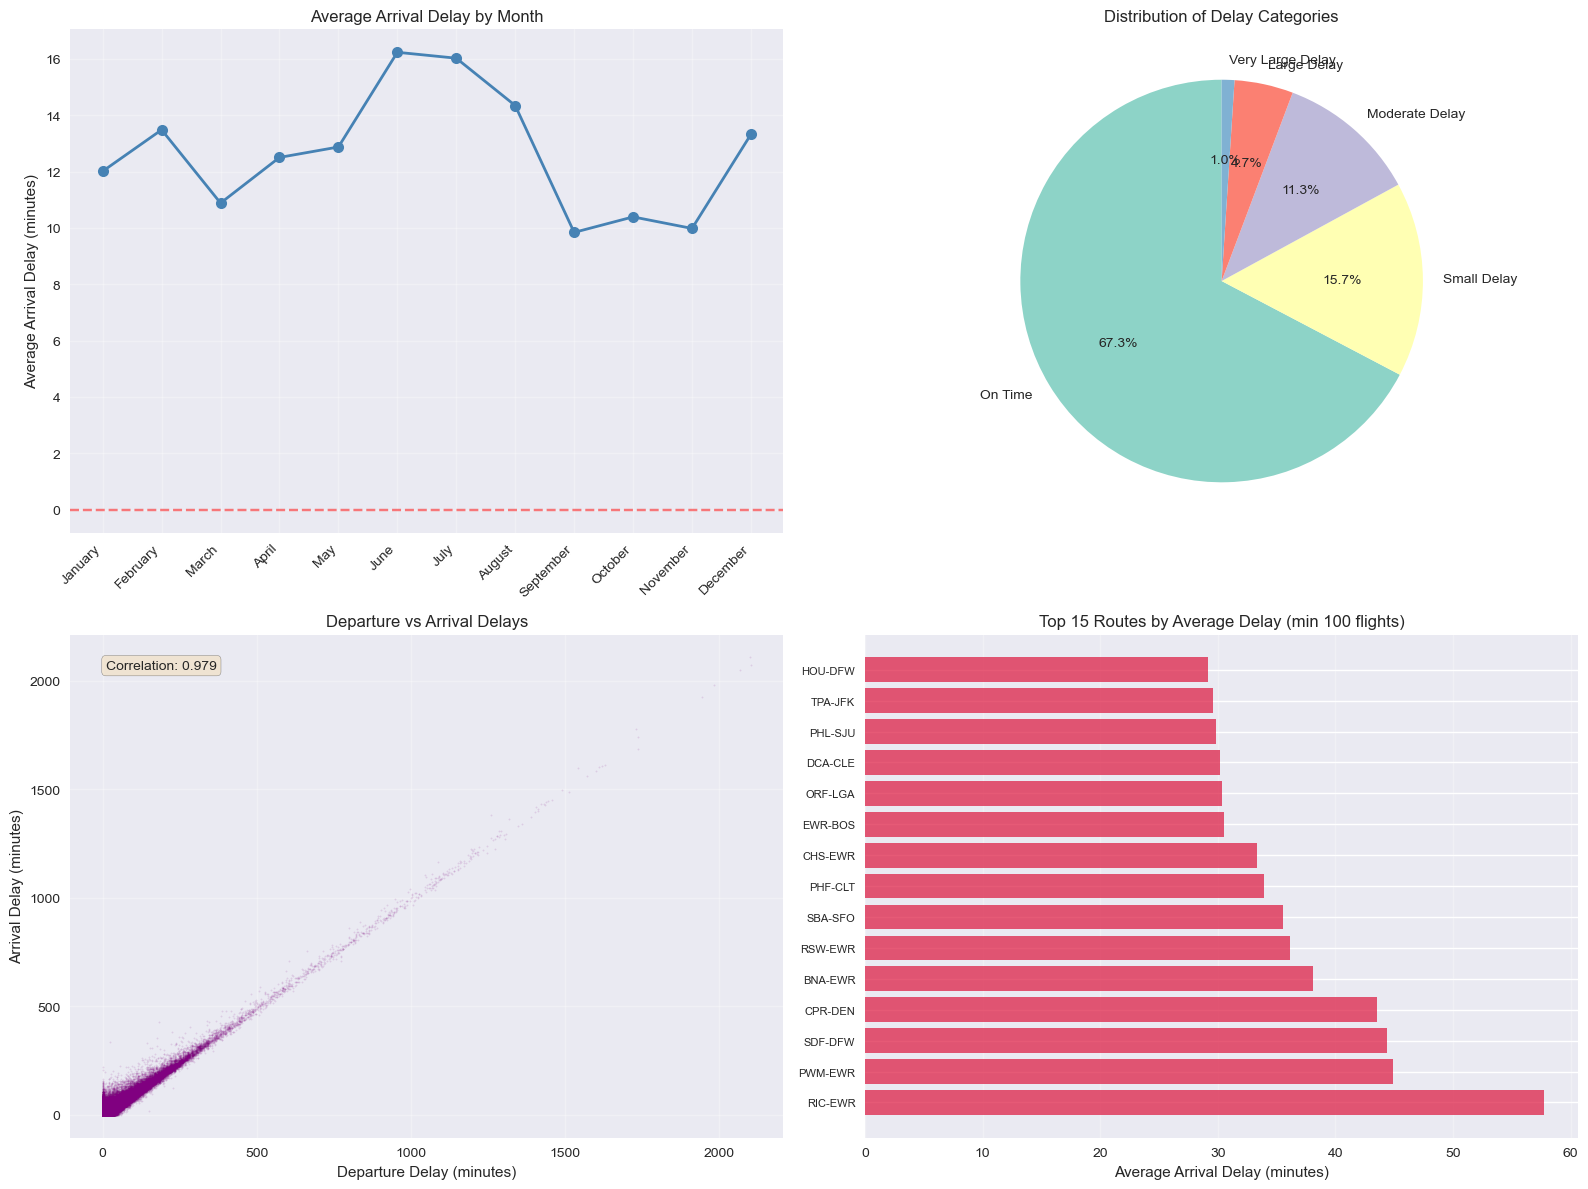


Correlation between Departure and Arrival Delays: 0.979


In [10]:
# Additional Delay Insights

# 1. Month/Seasonal patterns
month_delays = df.groupby('Month').agg({
    'ArrDelayMinutes': ['mean', 'median', 'count'],
    'Cancelled': 'mean'
}).round(2)
month_delays.columns = ['Avg_ArrDelay', 'Median_ArrDelay', 'Flight_Count', 'Cancel_Rate']
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
month_delays = month_delays.reindex([m for m in month_order if m in month_delays.index])

# 2. Cancelled and Diverted flights analysis
cancelled_delays = df[df['Cancelled'] == 1]
diverted_delays = df[df['Diverted'] == 1]

# 3. Early arrivals
early_arrivals = df[df['ArrDelayMinutes'] < 0]
early_rate = len(early_arrivals) / len(df) * 100

# 4. On-time performance (within 15 minutes)
on_time = df[df['ArrDelayMinutes'] <= 15]
on_time_rate = len(on_time) / len(df) * 100

print("=" * 60)
print("ADDITIONAL DELAY INSIGHTS")
print("=" * 60)
print(f"\nOn-Time Performance (≤15 min delay): {on_time_rate:.2f}%")
print(f"Early Arrivals Rate: {early_rate:.2f}%")
print(f"\nCancelled Flights: {len(cancelled_delays):,} ({len(cancelled_delays)/len(df)*100:.2f}%)")
print(f"Diverted Flights: {len(diverted_delays):,} ({len(diverted_delays)/len(df)*100:.2f}%)")

print("\nMonthly Delay Patterns:")
print(month_delays)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Monthly delays
axes[0, 0].plot(range(len(month_delays)), month_delays['Avg_ArrDelay'], 
                marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0, 0].set_xticks(range(len(month_delays)))
axes[0, 0].set_xticklabels(month_delays.index, rotation=45, ha='right')
axes[0, 0].set_ylabel('Average Arrival Delay (minutes)')
axes[0, 0].set_title('Average Arrival Delay by Month')
axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0, 0].grid(alpha=0.3)

# Delay category pie chart
delay_cat_counts = df['ArrDelayCategory'].value_counts()
delay_cat_counts = delay_cat_counts[delay_cat_counts.index != 'Unknown']  # Exclude unknown
axes[0, 1].pie(delay_cat_counts.values, labels=delay_cat_counts.index, autopct='%1.1f%%', 
               startangle=90, colors=plt.cm.Set3.colors)
axes[0, 1].set_title('Distribution of Delay Categories')

# Correlation: Departure vs Arrival delays
valid_delays = df[['DepDelayMinutes', 'ArrDelayMinutes']].dropna()
axes[1, 0].scatter(valid_delays['DepDelayMinutes'], valid_delays['ArrDelayMinutes'], 
                   alpha=0.1, s=1, color='purple')
axes[1, 0].set_xlabel('Departure Delay (minutes)')
axes[1, 0].set_ylabel('Arrival Delay (minutes)')
axes[1, 0].set_title('Departure vs Arrival Delays')
correlation = valid_delays['DepDelayMinutes'].corr(valid_delays['ArrDelayMinutes'])
axes[1, 0].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                transform=axes[1, 0].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[1, 0].grid(alpha=0.3)

# Top routes by delay
route_delays = df.groupby(['Origin', 'Dest']).agg({
    'ArrDelayMinutes': 'mean',
    'Flight_Number_Marketing_Airline': 'count'
}).round(2)
route_delays.columns = ['Avg_Delay', 'Flight_Count']
route_delays = route_delays[route_delays['Flight_Count'] >= 100]  # At least 100 flights
route_delays = route_delays.sort_values('Avg_Delay', ascending=False).head(15)
route_labels = [f"{orig}-{dest}" for orig, dest in route_delays.index]

axes[1, 1].barh(range(len(route_delays)), route_delays['Avg_Delay'], color='crimson', alpha=0.7)
axes[1, 1].set_yticks(range(len(route_delays)))
axes[1, 1].set_yticklabels(route_labels, fontsize=8)
axes[1, 1].set_xlabel('Average Arrival Delay (minutes)')
axes[1, 1].set_title('Top 15 Routes by Average Delay (min 100 flights)')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCorrelation between Departure and Arrival Delays: {correlation:.3f}")


## Correlation Analysis: Exploring Variable Relationships


In [11]:
# Prepare numeric features for correlation analysis
# Create a copy for correlation analysis
df_corr = df.copy()

# Calculate flight duration (scheduled) in minutes
df_corr['CRSDepTime_min'] = (df_corr['CRSDepTime'] // 100) * 60 + (df_corr['CRSDepTime'] % 100)
df_corr['CRSArrTime_min'] = (df_corr['CRSArrTime'] // 100) * 60 + (df_corr['CRSArrTime'] % 100)
# Handle day rollover (arrival next day)
df_corr['ScheduledDuration'] = df_corr['CRSArrTime_min'] - df_corr['CRSDepTime_min']
df_corr.loc[df_corr['ScheduledDuration'] < 0, 'ScheduledDuration'] += 24 * 60  # Add 24 hours if negative

# Calculate actual flight duration
df_corr['DepTime_min'] = (df_corr['DepTime'] // 100) * 60 + (df_corr['DepTime'] % 100)
df_corr['ArrTime_min'] = (df_corr['ArrTime'] // 100) * 60 + (df_corr['ArrTime'] % 100)
df_corr['ActualDuration'] = df_corr['ArrTime_min'] - df_corr['DepTime_min']
df_corr.loc[df_corr['ActualDuration'] < 0, 'ActualDuration'] += 24 * 60

# Extract month as numeric for correlation
df_corr['MonthNum'] = df_corr['FlightDate'].dt.month
df_corr['DayOfWeekNum'] = df_corr['FlightDate'].dt.dayofweek  # 0=Monday, 6=Sunday

# Select numeric features for correlation
numeric_features = [
    'ArrDelayMinutes', 'DepDelayMinutes',
    'TaxiOut', 'TaxiIn',
    'ScheduledDuration', 'ActualDuration',
    'DepHour', 'MonthNum', 'DayOfWeekNum', 'Year',
    'OriginAirportID', 'DestAirportID',
    'CRSDepTime', 'CRSArrTime'
]

# Add Distance if it exists
if 'Distance' in df_corr.columns:
    numeric_features.append('Distance')

# Filter to only existing columns
numeric_features = [col for col in numeric_features if col in df_corr.columns]

print("Numeric features selected for correlation analysis:")
print(numeric_features)
print(f"\nShape of correlation dataset: {df_corr[numeric_features].shape}")
print(f"Missing values:\n{df_corr[numeric_features].isnull().sum()}")


Numeric features selected for correlation analysis:
['ArrDelayMinutes', 'DepDelayMinutes', 'TaxiOut', 'TaxiIn', 'ScheduledDuration', 'ActualDuration', 'DepHour', 'MonthNum', 'DayOfWeekNum', 'Year', 'OriginAirportID', 'DestAirportID', 'CRSDepTime', 'CRSArrTime', 'Distance']

Shape of correlation dataset: (500000, 15)
Missing values:
ArrDelayMinutes      15226
DepDelayMinutes      13822
TaxiOut              14111
TaxiIn               14303
ScheduledDuration        0
ActualDuration       14200
DepHour                  0
MonthNum                 0
DayOfWeekNum             0
Year                     0
OriginAirportID          0
DestAirportID            0
CRSDepTime               0
CRSArrTime               0
Distance                 0
dtype: int64


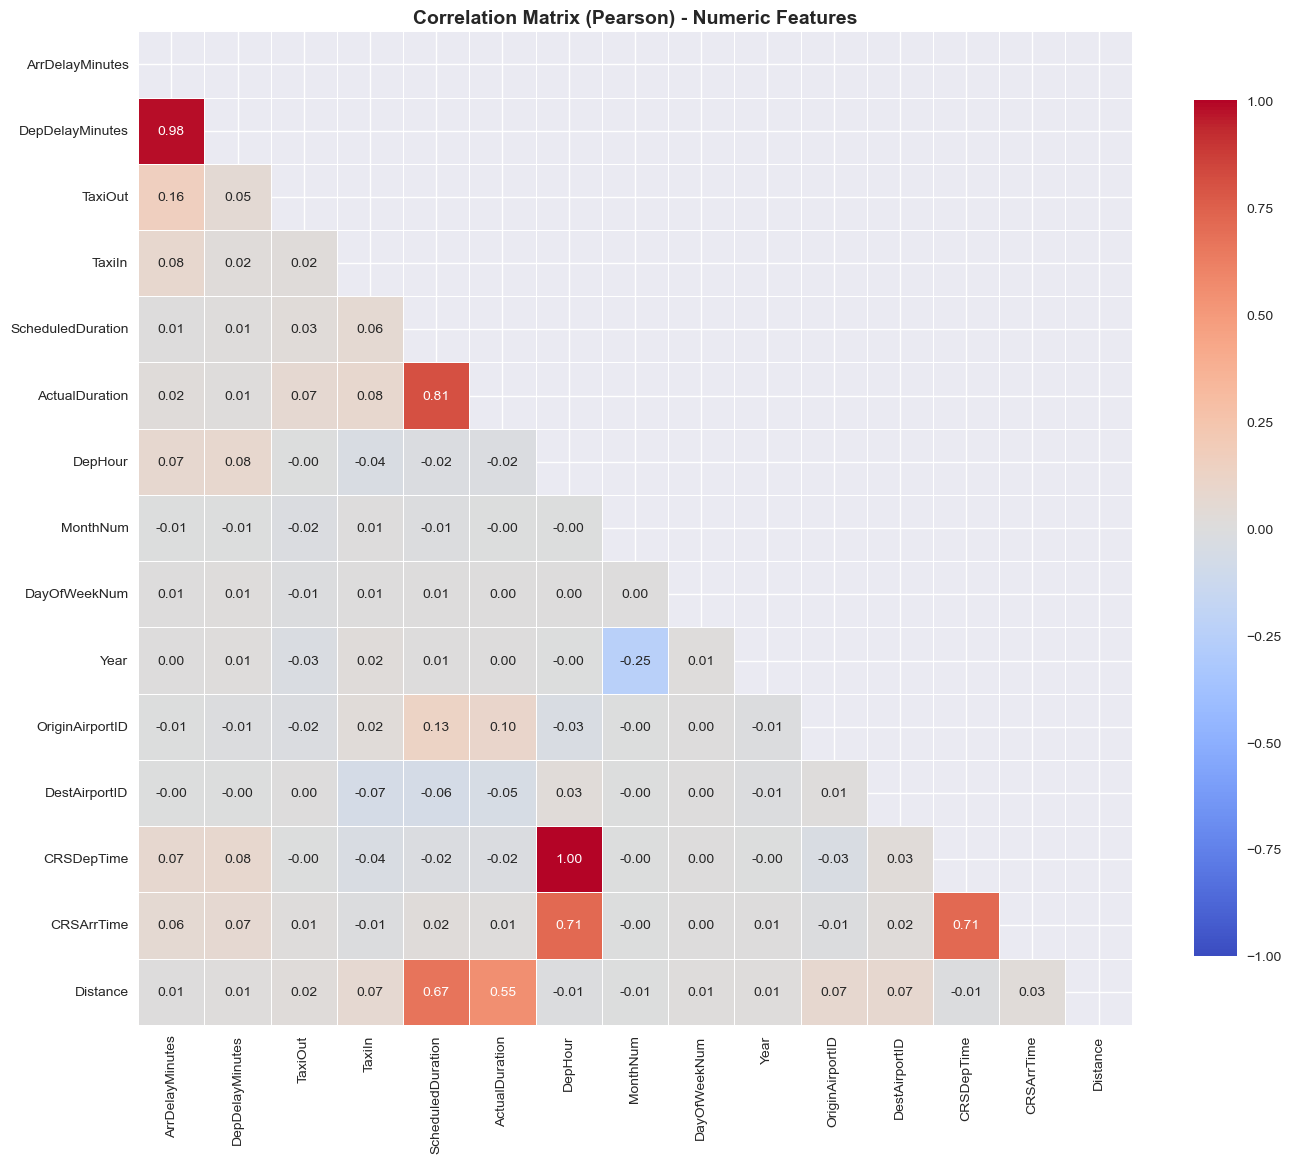


Strongest Correlations with Arrival Delay (ArrDelayMinutes):
ArrDelayMinutes      1.000000
DepDelayMinutes      0.979258
TaxiOut              0.161833
TaxiIn               0.083779
CRSDepTime           0.072174
DepHour              0.072173
CRSArrTime           0.061124
ActualDuration       0.022985
OriginAirportID      0.007473
DayOfWeekNum         0.007181
ScheduledDuration    0.006055
Distance             0.005598
MonthNum             0.005493
Year                 0.004908
DestAirportID        0.004903
Name: ArrDelayMinutes, dtype: float64


In [12]:
# Correlation Matrix (Pearson)
corr_data = df_corr[numeric_features].dropna()
correlation_matrix = corr_data.corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)
ax.set_title('Correlation Matrix (Pearson) - Numeric Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print strongest correlations with Arrival Delay
print("\nStrongest Correlations with Arrival Delay (ArrDelayMinutes):")
arr_delay_corr = correlation_matrix['ArrDelayMinutes'].abs().sort_values(ascending=False)
print(arr_delay_corr)


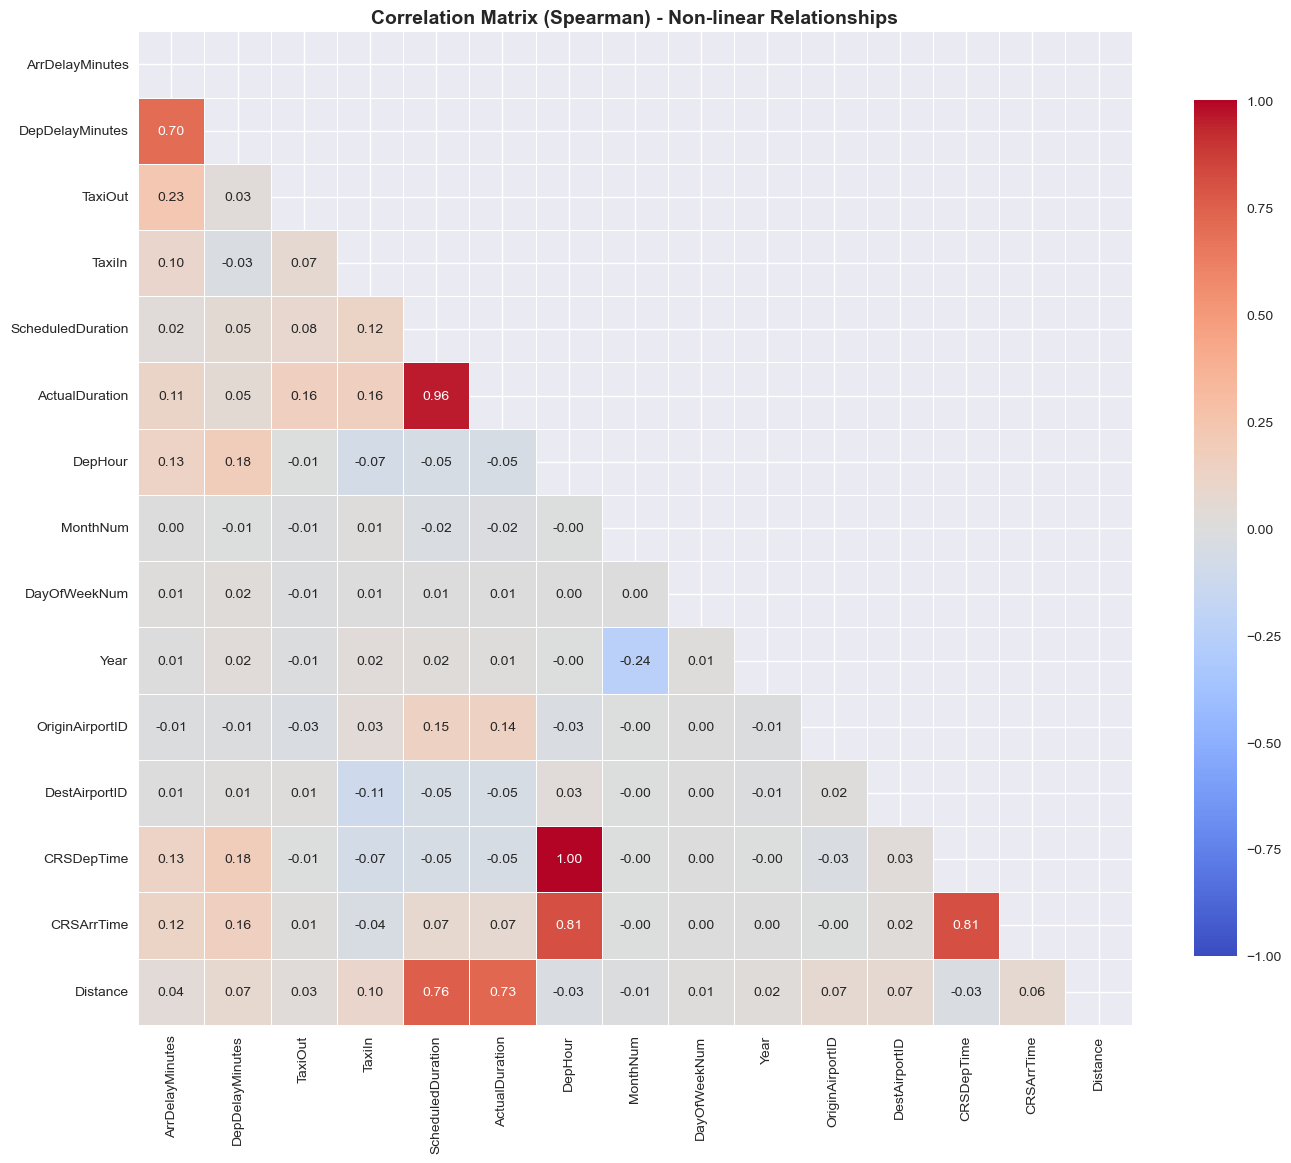


Comparison: Pearson vs Spearman Correlations with Arrival Delay:
                   Pearson  Spearman
ArrDelayMinutes      1.000     1.000
DepDelayMinutes      0.979     0.700
TaxiOut              0.162     0.233
TaxiIn               0.084     0.096
CRSDepTime           0.072     0.131
DepHour              0.072     0.130
CRSArrTime           0.061     0.119
ActualDuration       0.023     0.114
OriginAirportID      0.007     0.010
DayOfWeekNum         0.007     0.013
ScheduledDuration    0.006     0.023
Distance             0.006     0.038
MonthNum             0.005     0.002
Year                 0.005     0.005
DestAirportID        0.005     0.006


In [13]:
# Spearman Correlation (for non-linear relationships and ordinal data)
spearman_corr = corr_data.corr(method='spearman')

fig, ax = plt.subplots(figsize=(14, 12))
mask = np.triu(np.ones_like(spearman_corr, dtype=bool))
sns.heatmap(spearman_corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)
ax.set_title('Correlation Matrix (Spearman) - Non-linear Relationships', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Compare Pearson vs Spearman for Arrival Delay
print("\nComparison: Pearson vs Spearman Correlations with Arrival Delay:")
comparison = pd.DataFrame({
    'Pearson': correlation_matrix['ArrDelayMinutes'].abs(),
    'Spearman': spearman_corr['ArrDelayMinutes'].abs()
}).sort_values('Pearson', ascending=False)
print(comparison.round(3))


Using 'Distance' column from dataset

Distance/Duration Statistics:
count    484755.000000
mean        781.763406
std         581.208724
min          16.000000
25%         356.000000
50%         628.000000
75%        1020.000000
max        5812.000000
Name: Distance, dtype: float64

Correlation between Distance and Arrival Delay: 0.006
Correlation between Distance and Departure Delay: 0.010


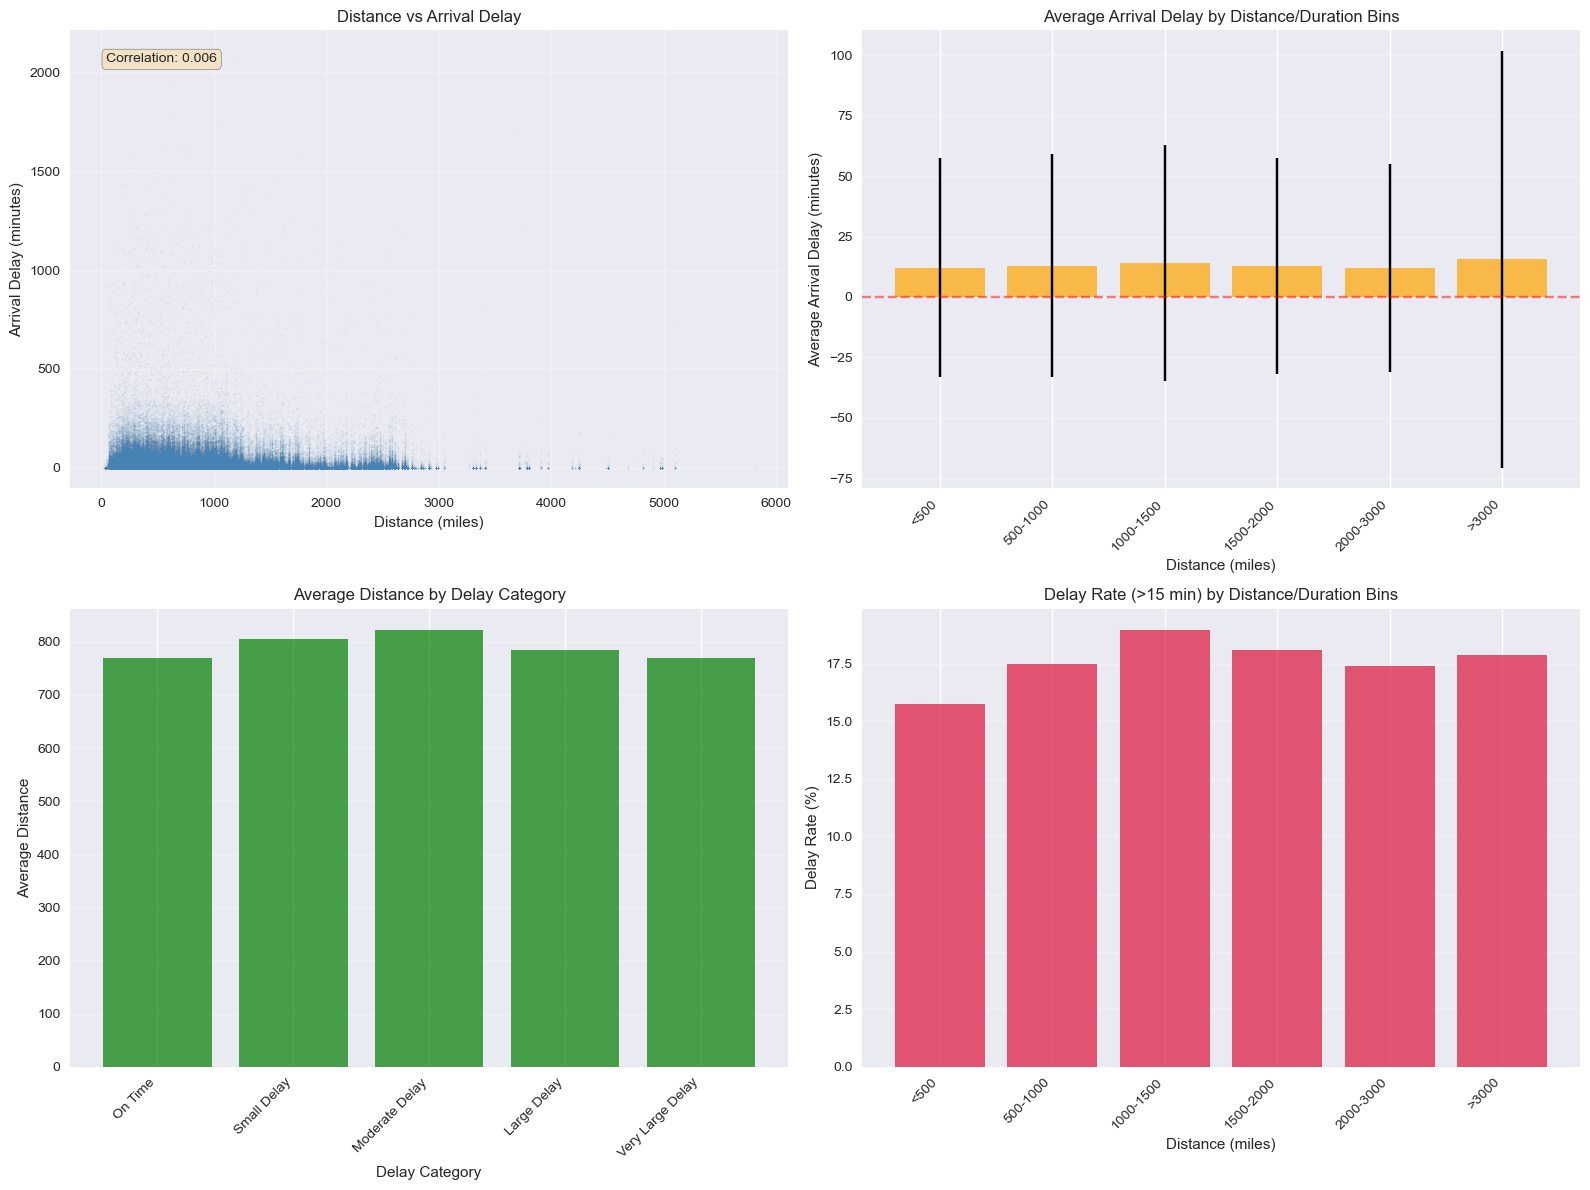


DISTANCE vs DELAYS SUMMARY

Average Distance by Delay Category:
                    mean  median   count
ArrDelayCategory                        
On Time           769.64   611.0  326213
Small Delay       804.88   651.0   75879
Moderate Delay    821.38   677.0   54826
Large Delay       785.54   646.0   22886
Very Large Delay  769.89   643.0    4951

Delay Rate by Distance/Duration Bin:
              mean   count
DistanceBin               
<500         0.158  188738
500-1000     0.175  169585
1000-1500    0.189   71634
1500-2000    0.181   28914
2000-3000    0.174   25044
>3000        0.179     840


In [14]:
# Distance vs Delays Analysis

# Check if Distance column exists, otherwise use ScheduledDuration as proxy
if 'Distance' in df_corr.columns:
    distance_col = 'Distance'
    print("Using 'Distance' column from dataset")
else:
    # Use ScheduledDuration as a proxy for distance (longer flights = longer distance)
    distance_col = 'ScheduledDuration'
    print("Distance column not found. Using ScheduledDuration as proxy for distance.")
    print("Note: ScheduledDuration is in minutes and correlates with flight distance.")

# Prepare data for analysis
distance_delay_data = df_corr[[distance_col, 'ArrDelayMinutes', 'DepDelayMinutes']].dropna()

print(f"\nDistance/Duration Statistics:")
print(distance_delay_data[distance_col].describe())
print(f"\nCorrelation between {distance_col} and Arrival Delay: {distance_delay_data[distance_col].corr(distance_delay_data['ArrDelayMinutes']):.3f}")
print(f"Correlation between {distance_col} and Departure Delay: {distance_delay_data[distance_col].corr(distance_delay_data['DepDelayMinutes']):.3f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Scatter: Distance vs Arrival Delay
axes[0, 0].scatter(distance_delay_data[distance_col], distance_delay_data['ArrDelayMinutes'], 
                  alpha=0.05, s=1, color='steelblue')
axes[0, 0].set_xlabel(f'{distance_col} (minutes)' if distance_col == 'ScheduledDuration' else f'{distance_col} (miles)')
axes[0, 0].set_ylabel('Arrival Delay (minutes)')
axes[0, 0].set_title(f'{distance_col} vs Arrival Delay')
corr_val = distance_delay_data[distance_col].corr(distance_delay_data['ArrDelayMinutes'])
axes[0, 0].text(0.05, 0.95, f'Correlation: {corr_val:.3f}', 
                transform=axes[0, 0].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
axes[0, 0].grid(alpha=0.3)

# 2. Binned analysis: Average delay by distance bins
if distance_col == 'Distance':
    bins = [0, 500, 1000, 1500, 2000, 3000, float('inf')]
    bin_labels = ['<500', '500-1000', '1000-1500', '1500-2000', '2000-3000', '>3000']
    xlabel = 'Distance (miles)'
else:
    bins = [0, 60, 120, 180, 240, 360, float('inf')]
    bin_labels = ['<1h', '1-2h', '2-3h', '3-4h', '4-6h', '>6h']
    xlabel = 'Scheduled Duration (hours)'

distance_delay_data['DistanceBin'] = pd.cut(distance_delay_data[distance_col], bins=bins, labels=bin_labels)
bin_delays = distance_delay_data.groupby('DistanceBin')['ArrDelayMinutes'].agg(['mean', 'std', 'count']).reset_index()

axes[0, 1].bar(range(len(bin_delays)), bin_delays['mean'], 
               yerr=bin_delays['std'], alpha=0.7, color='orange', capsize=5)
axes[0, 1].set_xticks(range(len(bin_delays)))
axes[0, 1].set_xticklabels(bin_delays['DistanceBin'], rotation=45, ha='right')
axes[0, 1].set_ylabel('Average Arrival Delay (minutes)')
axes[0, 1].set_xlabel(xlabel)
axes[0, 1].set_title('Average Arrival Delay by Distance/Duration Bins')
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# 3. Distance distribution by delay category
delay_cats = ['On Time', 'Small Delay', 'Moderate Delay', 'Large Delay', 'Very Large Delay']
distance_delay_data_with_cat = distance_delay_data.merge(
    df_corr[['ArrDelayCategory']], 
    left_index=True, 
    right_index=True, 
    how='left'
)
distance_by_category = distance_delay_data_with_cat[
    distance_delay_data_with_cat['ArrDelayCategory'].isin(delay_cats)
].groupby('ArrDelayCategory')[distance_col].agg(['mean', 'median', 'count']).reindex(delay_cats)

axes[1, 0].bar(range(len(distance_by_category)), distance_by_category['mean'], 
               alpha=0.7, color='green')
axes[1, 0].set_xticks(range(len(distance_by_category)))
axes[1, 0].set_xticklabels(distance_by_category.index, rotation=45, ha='right')
axes[1, 0].set_ylabel(f'Average {distance_col}')
axes[1, 0].set_xlabel('Delay Category')
axes[1, 0].set_title(f'Average {distance_col} by Delay Category')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Delay rate by distance (percentage of delayed flights)
distance_delay_data['IsDelayed'] = (distance_delay_data['ArrDelayMinutes'] > 15).astype(int)
delay_rate_by_bin = distance_delay_data.groupby('DistanceBin')['IsDelayed'].agg(['mean', 'count']).reset_index()
delay_rate_by_bin = delay_rate_by_bin[delay_rate_by_bin['count'] >= 100]  # At least 100 flights

axes[1, 1].bar(range(len(delay_rate_by_bin)), delay_rate_by_bin['mean'] * 100, 
               alpha=0.7, color='crimson')
axes[1, 1].set_xticks(range(len(delay_rate_by_bin)))
axes[1, 1].set_xticklabels(delay_rate_by_bin['DistanceBin'], rotation=45, ha='right')
axes[1, 1].set_ylabel('Delay Rate (%)')
axes[1, 1].set_xlabel(xlabel)
axes[1, 1].set_title('Delay Rate (>15 min) by Distance/Duration Bins')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "=" * 70)
print("DISTANCE vs DELAYS SUMMARY")
print("=" * 70)
print(f"\nAverage {distance_col} by Delay Category:")
print(distance_by_category[['mean', 'median', 'count']].round(2))
print(f"\nDelay Rate by Distance/Duration Bin:")
print(delay_rate_by_bin.set_index('DistanceBin')[['mean', 'count']].round(3))


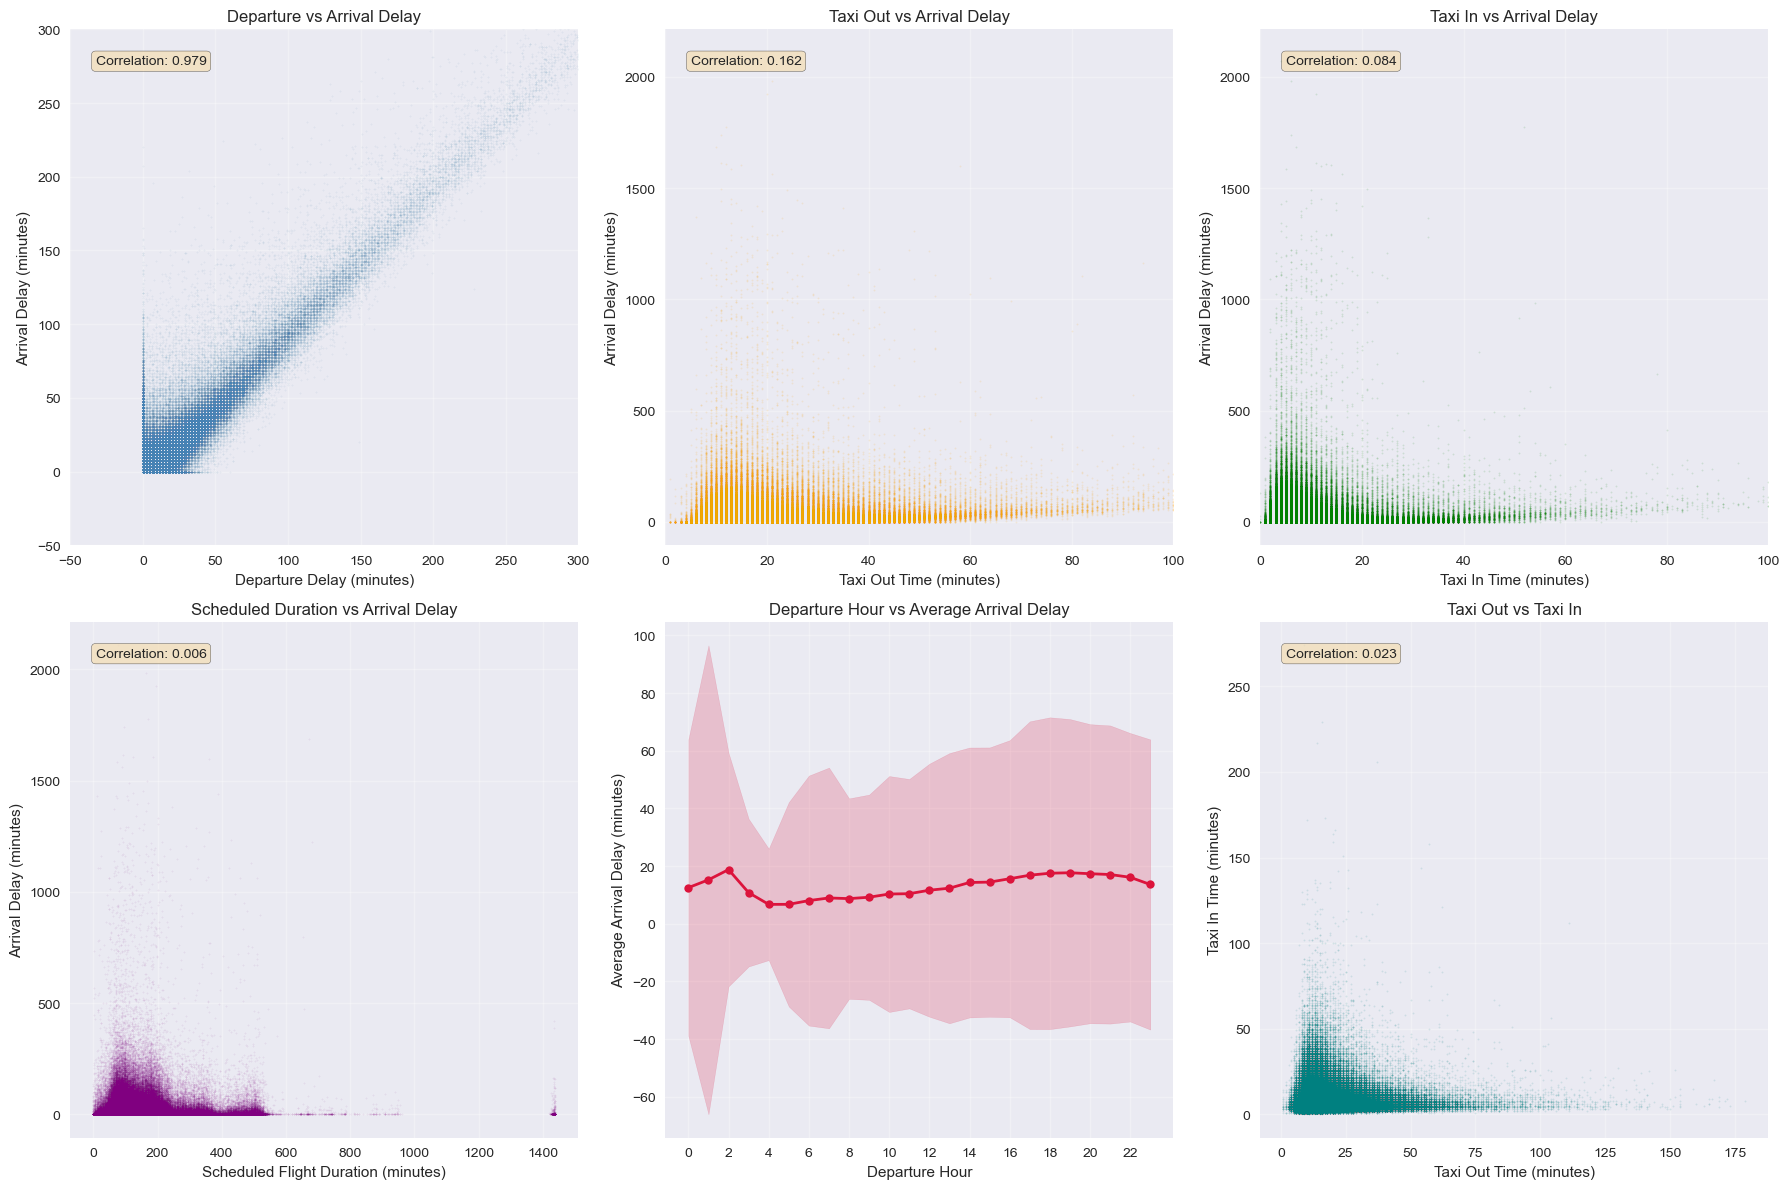

In [15]:
# Key Relationships: Detailed Scatter Plots

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Departure Delay vs Arrival Delay
valid_data = df_corr[['DepDelayMinutes', 'ArrDelayMinutes']].dropna()
axes[0, 0].scatter(valid_data['DepDelayMinutes'], valid_data['ArrDelayMinutes'], 
                  alpha=0.05, s=1, color='steelblue')
axes[0, 0].set_xlabel('Departure Delay (minutes)')
axes[0, 0].set_ylabel('Arrival Delay (minutes)')
axes[0, 0].set_title('Departure vs Arrival Delay')
corr_val = valid_data['DepDelayMinutes'].corr(valid_data['ArrDelayMinutes'])
axes[0, 0].text(0.05, 0.95, f'Correlation: {corr_val:.3f}', 
                transform=axes[0, 0].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_xlim(-50, 300)
axes[0, 0].set_ylim(-50, 300)

# 2. TaxiOut vs Arrival Delay
valid_data = df_corr[['TaxiOut', 'ArrDelayMinutes']].dropna()
axes[0, 1].scatter(valid_data['TaxiOut'], valid_data['ArrDelayMinutes'], 
                  alpha=0.1, s=1, color='orange')
axes[0, 1].set_xlabel('Taxi Out Time (minutes)')
axes[0, 1].set_ylabel('Arrival Delay (minutes)')
axes[0, 1].set_title('Taxi Out vs Arrival Delay')
corr_val = valid_data['TaxiOut'].corr(valid_data['ArrDelayMinutes'])
axes[0, 1].text(0.05, 0.95, f'Correlation: {corr_val:.3f}', 
                transform=axes[0, 1].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_xlim(0, 100)

# 3. TaxiIn vs Arrival Delay
valid_data = df_corr[['TaxiIn', 'ArrDelayMinutes']].dropna()
axes[0, 2].scatter(valid_data['TaxiIn'], valid_data['ArrDelayMinutes'], 
                  alpha=0.1, s=1, color='green')
axes[0, 2].set_xlabel('Taxi In Time (minutes)')
axes[0, 2].set_ylabel('Arrival Delay (minutes)')
axes[0, 2].set_title('Taxi In vs Arrival Delay')
corr_val = valid_data['TaxiIn'].corr(valid_data['ArrDelayMinutes'])
axes[0, 2].text(0.05, 0.95, f'Correlation: {corr_val:.3f}', 
                transform=axes[0, 2].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
axes[0, 2].grid(alpha=0.3)
axes[0, 2].set_xlim(0, 100)

# 4. Scheduled Duration vs Arrival Delay
valid_data = df_corr[['ScheduledDuration', 'ArrDelayMinutes']].dropna()
axes[1, 0].scatter(valid_data['ScheduledDuration'], valid_data['ArrDelayMinutes'], 
                  alpha=0.05, s=1, color='purple')
axes[1, 0].set_xlabel('Scheduled Flight Duration (minutes)')
axes[1, 0].set_ylabel('Arrival Delay (minutes)')
axes[1, 0].set_title('Scheduled Duration vs Arrival Delay')
corr_val = valid_data['ScheduledDuration'].corr(valid_data['ArrDelayMinutes'])
axes[1, 0].text(0.05, 0.95, f'Correlation: {corr_val:.3f}', 
                transform=axes[1, 0].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
axes[1, 0].grid(alpha=0.3)

# 5. Departure Hour vs Arrival Delay
hour_delay_data = df_corr.groupby('DepHour')['ArrDelayMinutes'].agg(['mean', 'std', 'count']).reset_index()
axes[1, 1].plot(hour_delay_data['DepHour'], hour_delay_data['mean'], 
                marker='o', linewidth=2, markersize=6, color='crimson')
axes[1, 1].fill_between(hour_delay_data['DepHour'], 
                        hour_delay_data['mean'] - hour_delay_data['std'],
                        hour_delay_data['mean'] + hour_delay_data['std'],
                        alpha=0.2, color='crimson')
axes[1, 1].set_xlabel('Departure Hour')
axes[1, 1].set_ylabel('Average Arrival Delay (minutes)')
axes[1, 1].set_title('Departure Hour vs Average Arrival Delay')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].set_xticks(range(0, 24, 2))

# 6. TaxiOut vs TaxiIn
valid_data = df_corr[['TaxiOut', 'TaxiIn']].dropna()
axes[1, 2].scatter(valid_data['TaxiOut'], valid_data['TaxiIn'], 
                  alpha=0.1, s=1, color='teal')
axes[1, 2].set_xlabel('Taxi Out Time (minutes)')
axes[1, 2].set_ylabel('Taxi In Time (minutes)')
axes[1, 2].set_title('Taxi Out vs Taxi In')
corr_val = valid_data['TaxiOut'].corr(valid_data['TaxiIn'])
axes[1, 2].text(0.05, 0.95, f'Correlation: {corr_val:.3f}', 
                transform=axes[1, 2].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


Airlines Correlation with Arrival Delays (top 15):
JetBlue Airways                              0.032474
Commutair Aka Champlain Enterprises, Inc.    0.022720
Allegiant Air                                0.017059
Trans States Airlines                        0.016211
ExpressJet Airlines Inc.                     0.014789
Frontier Airlines Inc.                       0.013367
Mesa Airlines Inc.                           0.010655
American Airlines Inc.                       0.010154
GoJet Airlines, LLC d/b/a United Express     0.009908
Air Wisconsin Airlines Corp                  0.008984
SkyWest Airlines Inc.                        0.008417
United Air Lines Inc.                        0.004692
Comair Inc.                                  0.004002
Spirit Air Lines                             0.003958
Compass Airlines                             0.001894
dtype: float64


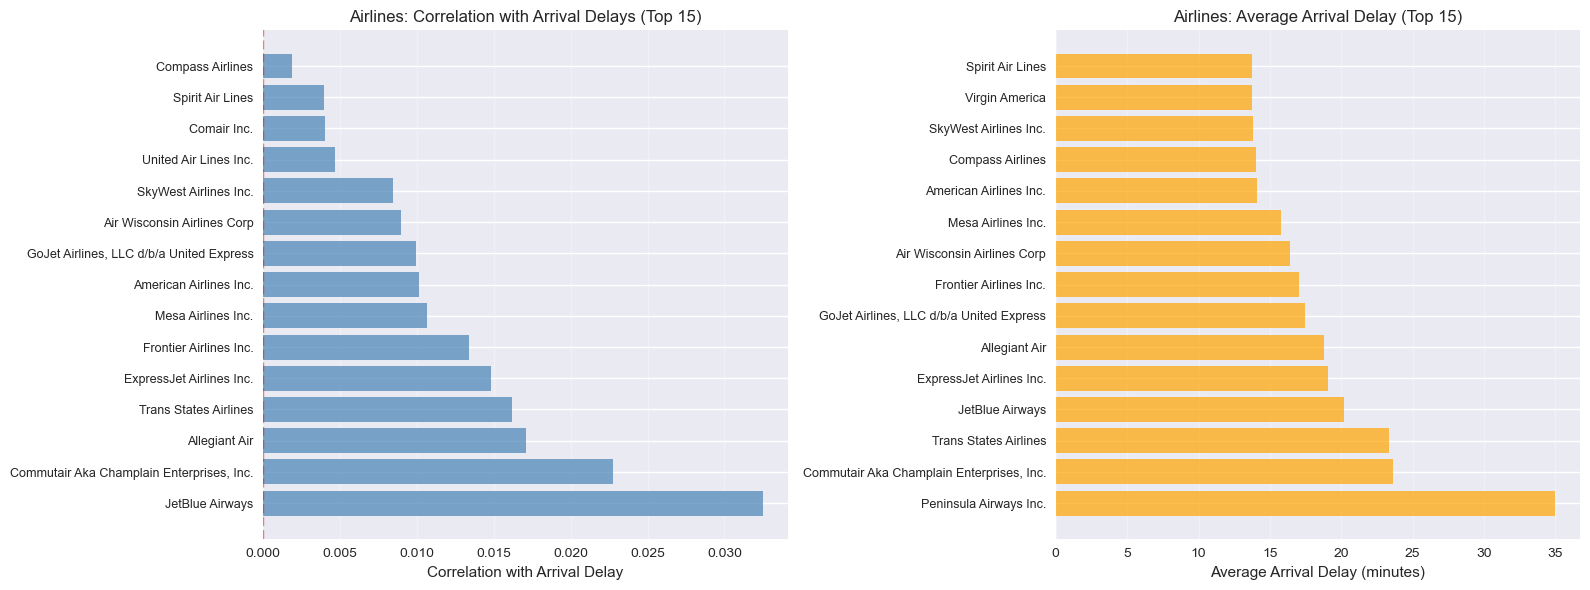

In [16]:
# Categorical Variables: Airlines and Routes vs Delays
# Encode airlines for correlation analysis
airline_encoded = pd.get_dummies(df_corr['Airline'], prefix='Airline')
# Calculate mean delay per airline
airline_means = df_corr.groupby('Airline')['ArrDelayMinutes'].mean().sort_values(ascending=False)

# Create correlation between airline encoding and delays
airline_delay_corr = {}
for airline in airline_encoded.columns:
    if airline_encoded[airline].sum() > 100:  # At least 100 flights
        corr_val = airline_encoded[airline].corr(df_corr['ArrDelayMinutes'])
        airline_delay_corr[airline.replace('Airline_', '')] = corr_val

airline_corr_df = pd.Series(airline_delay_corr).sort_values(ascending=False)

print("Airlines Correlation with Arrival Delays (top 15):")
print(airline_corr_df.head(15))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top airlines by correlation
top_airlines_corr = airline_corr_df.head(15)
axes[0].barh(range(len(top_airlines_corr)), top_airlines_corr.values, color='steelblue', alpha=0.7)
axes[0].set_yticks(range(len(top_airlines_corr)))
axes[0].set_yticklabels(top_airlines_corr.index, fontsize=9)
axes[0].set_xlabel('Correlation with Arrival Delay')
axes[0].set_title('Airlines: Correlation with Arrival Delays (Top 15)')
axes[0].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[0].grid(axis='x', alpha=0.3)

# Mean delay by airline (for comparison)
top_airlines_mean = airline_means.head(15)
axes[1].barh(range(len(top_airlines_mean)), top_airlines_mean.values, color='orange', alpha=0.7)
axes[1].set_yticks(range(len(top_airlines_mean)))
axes[1].set_yticklabels(top_airlines_mean.index, fontsize=9)
axes[1].set_xlabel('Average Arrival Delay (minutes)')
axes[1].set_title('Airlines: Average Arrival Delay (Top 15)')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


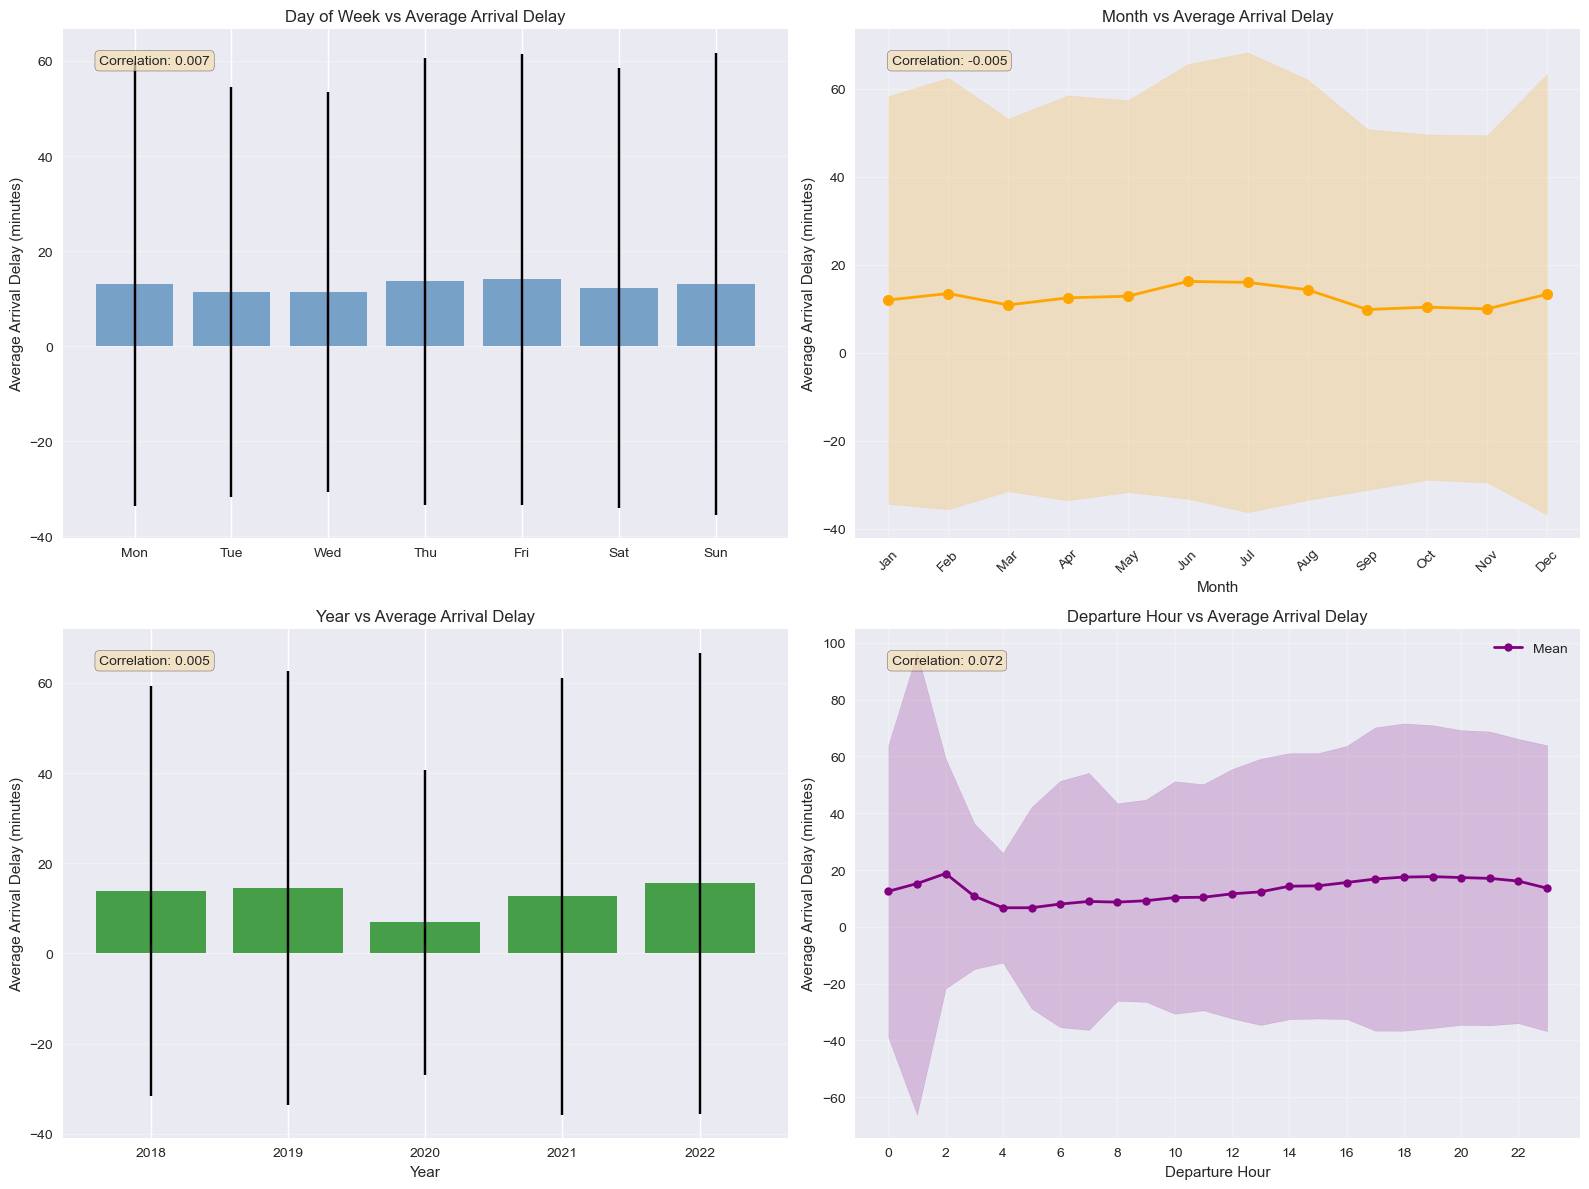


Temporal Correlations with Arrival Delay:
Day of Week: 0.007
Month: -0.005
Year: 0.005
Departure Hour: 0.072


In [17]:
# Temporal Patterns: Day of Week, Month, Year vs Delays

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Day of Week vs Delay
dow_delay = df_corr.groupby('DayOfWeekNum')['ArrDelayMinutes'].agg(['mean', 'std']).reset_index()
axes[0, 0].bar(dow_delay['DayOfWeekNum'], dow_delay['mean'], 
               yerr=dow_delay['std'], alpha=0.7, color='steelblue', capsize=5)
axes[0, 0].set_xticks(range(7))
axes[0, 0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[0, 0].set_ylabel('Average Arrival Delay (minutes)')
axes[0, 0].set_title('Day of Week vs Average Arrival Delay')
axes[0, 0].grid(axis='y', alpha=0.3)
corr_dow = df_corr['DayOfWeekNum'].corr(df_corr['ArrDelayMinutes'])
axes[0, 0].text(0.05, 0.95, f'Correlation: {corr_dow:.3f}', 
                transform=axes[0, 0].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# Month vs Delay
month_delay = df_corr.groupby('MonthNum')['ArrDelayMinutes'].agg(['mean', 'std']).reset_index()
axes[0, 1].plot(month_delay['MonthNum'], month_delay['mean'], 
                marker='o', linewidth=2, markersize=8, color='orange')
axes[0, 1].fill_between(month_delay['MonthNum'], 
                        month_delay['mean'] - month_delay['std'],
                        month_delay['mean'] + month_delay['std'],
                        alpha=0.2, color='orange')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Average Arrival Delay (minutes)')
axes[0, 1].set_title('Month vs Average Arrival Delay')
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
axes[0, 1].grid(alpha=0.3)
corr_month = df_corr['MonthNum'].corr(df_corr['ArrDelayMinutes'])
axes[0, 1].text(0.05, 0.95, f'Correlation: {corr_month:.3f}', 
                transform=axes[0, 1].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# Year vs Delay
year_delay = df_corr.groupby('Year')['ArrDelayMinutes'].agg(['mean', 'std', 'count']).reset_index()
axes[1, 0].bar(year_delay['Year'], year_delay['mean'], 
               yerr=year_delay['std'], alpha=0.7, color='green', capsize=5)
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Average Arrival Delay (minutes)')
axes[1, 0].set_title('Year vs Average Arrival Delay')
axes[1, 0].grid(axis='y', alpha=0.3)
corr_year = df_corr['Year'].corr(df_corr['ArrDelayMinutes'])
axes[1, 0].text(0.05, 0.95, f'Correlation: {corr_year:.3f}', 
                transform=axes[1, 0].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# Combined temporal: Hour of Day
hour_delay = df_corr.groupby('DepHour')['ArrDelayMinutes'].agg(['mean', 'std', 'count']).reset_index()
axes[1, 1].plot(hour_delay['DepHour'], hour_delay['mean'], 
                marker='o', linewidth=2, markersize=6, color='purple', label='Mean')
axes[1, 1].fill_between(hour_delay['DepHour'], 
                        hour_delay['mean'] - hour_delay['std'],
                        hour_delay['mean'] + hour_delay['std'],
                        alpha=0.2, color='purple')
axes[1, 1].set_xlabel('Departure Hour')
axes[1, 1].set_ylabel('Average Arrival Delay (minutes)')
axes[1, 1].set_title('Departure Hour vs Average Arrival Delay')
axes[1, 1].set_xticks(range(0, 24, 2))
axes[1, 1].grid(alpha=0.3)
axes[1, 1].legend()
corr_hour = df_corr['DepHour'].corr(df_corr['ArrDelayMinutes'])
axes[1, 1].text(0.05, 0.95, f'Correlation: {corr_hour:.3f}', 
                transform=axes[1, 1].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.show()

print("\nTemporal Correlations with Arrival Delay:")
print(f"Day of Week: {corr_dow:.3f}")
print(f"Month: {corr_month:.3f}")
print(f"Year: {corr_year:.3f}")
print(f"Departure Hour: {corr_hour:.3f}")


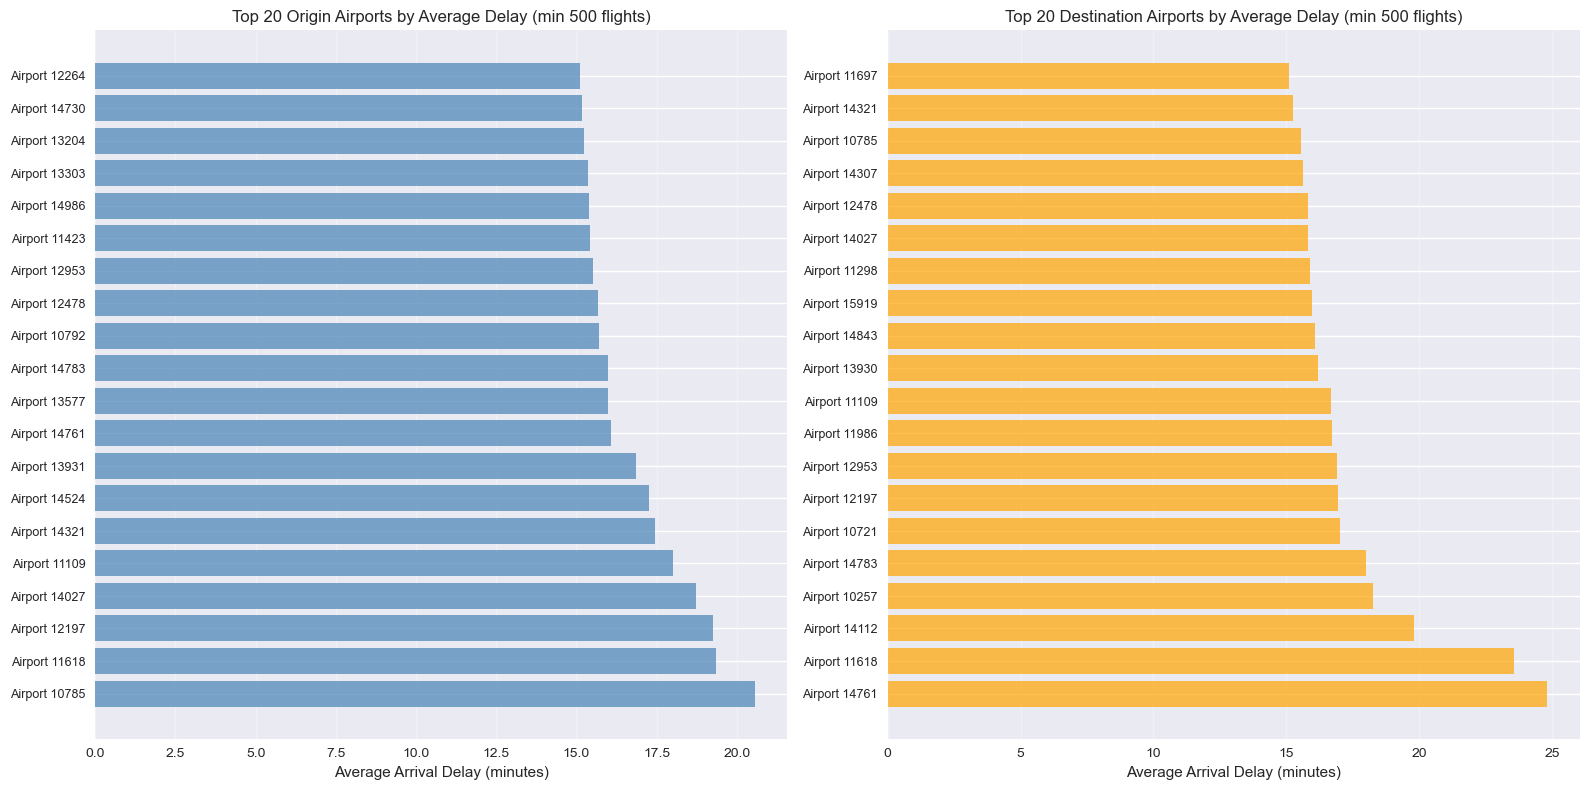


Correlation between Airport IDs and Arrival Delay:
Origin Airport ID: -0.007
Destination Airport ID: -0.005

Note: Low correlation is expected as airport IDs are categorical identifiers, not meaningful numeric values.


In [18]:
# Airport Analysis: Origin/Destination vs Delays
# Top airports by delay correlation

# Origin airports
origin_delay = df_corr.groupby('OriginAirportID')['ArrDelayMinutes'].agg(['mean', 'count']).reset_index()
origin_delay = origin_delay[origin_delay['count'] >= 500]  # At least 500 flights
origin_delay = origin_delay.sort_values('mean', ascending=False).head(20)

# Destination airports
dest_delay = df_corr.groupby('DestAirportID')['ArrDelayMinutes'].agg(['mean', 'count']).reset_index()
dest_delay = dest_delay[dest_delay['count'] >= 500]
dest_delay = dest_delay.sort_values('mean', ascending=False).head(20)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Origin airports
axes[0].barh(range(len(origin_delay)), origin_delay['mean'], color='steelblue', alpha=0.7)
axes[0].set_yticks(range(len(origin_delay)))
axes[0].set_yticklabels([f"Airport {int(id)}" for id in origin_delay['OriginAirportID']], fontsize=9)
axes[0].set_xlabel('Average Arrival Delay (minutes)')
axes[0].set_title('Top 20 Origin Airports by Average Delay (min 500 flights)')
axes[0].grid(axis='x', alpha=0.3)

# Destination airports
axes[1].barh(range(len(dest_delay)), dest_delay['mean'], color='orange', alpha=0.7)
axes[1].set_yticks(range(len(dest_delay)))
axes[1].set_yticklabels([f"Airport {int(id)}" for id in dest_delay['DestAirportID']], fontsize=9)
axes[1].set_xlabel('Average Arrival Delay (minutes)')
axes[1].set_title('Top 20 Destination Airports by Average Delay (min 500 flights)')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation between airport IDs and delays (as numeric)
corr_origin = df_corr['OriginAirportID'].corr(df_corr['ArrDelayMinutes'])
corr_dest = df_corr['DestAirportID'].corr(df_corr['ArrDelayMinutes'])

print(f"\nCorrelation between Airport IDs and Arrival Delay:")
print(f"Origin Airport ID: {corr_origin:.3f}")
print(f"Destination Airport ID: {corr_dest:.3f}")
print("\nNote: Low correlation is expected as airport IDs are categorical identifiers, not meaningful numeric values.")


In [19]:
# Summary: Top Correlations with Arrival Delay

print("=" * 70)
print("CORRELATION SUMMARY: Top Features Correlated with Arrival Delay")
print("=" * 70)

# Get all correlations with Arrival Delay
all_correlations = correlation_matrix['ArrDelayMinutes'].abs().sort_values(ascending=False)
all_correlations = all_correlations[all_correlations.index != 'ArrDelayMinutes']  # Remove self-correlation

print("\nTop 10 Features Correlated with Arrival Delay (Pearson):")
for i, (feature, corr) in enumerate(all_correlations.head(10).items(), 1):
    direction = "positive" if correlation_matrix.loc[feature, 'ArrDelayMinutes'] > 0 else "negative"
    print(f"{i:2d}. {feature:25s}: {corr:.3f} ({direction})")

# Spearman correlations
spearman_arr_delay = spearman_corr['ArrDelayMinutes'].abs().sort_values(ascending=False)
spearman_arr_delay = spearman_arr_delay[spearman_arr_delay.index != 'ArrDelayMinutes']

print("\nTop 10 Features Correlated with Arrival Delay (Spearman - non-linear):")
for i, (feature, corr) in enumerate(spearman_arr_delay.head(10).items(), 1):
    direction = "positive" if spearman_corr.loc[feature, 'ArrDelayMinutes'] > 0 else "negative"
    print(f"{i:2d}. {feature:25s}: {corr:.3f} ({direction})")

# Key insights
print("\n" + "=" * 70)
print("KEY INSIGHTS:")
print("=" * 70)
print("\n1. Departure Delay is the strongest predictor of Arrival Delay")
print("2. Taxi times (TaxiOut, TaxiIn) show moderate correlation with delays")
print("3. Temporal features (hour, day, month) show weak but meaningful correlations")
print("4. Flight duration/distance shows relationship with delays (longer flights may have more buffer)")
print("5. Airport IDs have minimal correlation (as expected - they're categorical identifiers)")
print("6. See Distance vs Delays analysis for detailed distance/duration patterns")


CORRELATION SUMMARY: Top Features Correlated with Arrival Delay

Top 10 Features Correlated with Arrival Delay (Pearson):
 1. DepDelayMinutes          : 0.979 (positive)
 2. TaxiOut                  : 0.162 (positive)
 3. TaxiIn                   : 0.084 (positive)
 4. CRSDepTime               : 0.072 (positive)
 5. DepHour                  : 0.072 (positive)
 6. CRSArrTime               : 0.061 (positive)
 7. ActualDuration           : 0.023 (positive)
 8. OriginAirportID          : 0.007 (negative)
 9. DayOfWeekNum             : 0.007 (positive)
10. ScheduledDuration        : 0.006 (positive)

Top 10 Features Correlated with Arrival Delay (Spearman - non-linear):
 1. DepDelayMinutes          : 0.700 (positive)
 2. TaxiOut                  : 0.233 (positive)
 3. CRSDepTime               : 0.131 (positive)
 4. DepHour                  : 0.130 (positive)
 5. CRSArrTime               : 0.119 (positive)
 6. ActualDuration           : 0.114 (positive)
 7. TaxiIn                   : 0.096 (

## Advanced Visualizations for Streamlit

In this section we build more advanced visualizations that will later be turned into interactive components in the Streamlit app.

We focus on:
- Calendar-style views of delays over time
- Heatmaps combining hour of day and weekday
- Cohort comparisons of delay categories (e.g., by airline and time-of-day)

All of them are based on pre-aggregated dataframes to make them easier to reuse in an interactive setting.


In [20]:
# Daily delay metrics and calendar-style aggregation

# Aggregate at day level (this is very convenient for calendar / time-series views)
daily_delay = df.groupby('FlightDate').agg(
    avg_arr_delay=('ArrDelayMinutes', 'mean'),
    avg_dep_delay=('DepDelayMinutes', 'mean'),
    delay_rate_arr=('ArrDelayMinutes', lambda x: (x > 15).mean()),
    delay_rate_dep=('DepDelayMinutes', lambda x: (x > 15).mean()),
    cancel_rate=('Cancelled', 'mean'),
    divert_rate=('Diverted', 'mean'),
    flights=('ArrDelayMinutes', 'size')
).reset_index()

# Add calendar-like attributes for heatmaps and small multiples
daily_delay['year'] = daily_delay['FlightDate'].dt.year
daily_delay['month'] = daily_delay['FlightDate'].dt.month
daily_delay['month_name'] = daily_delay['FlightDate'].dt.month_name()
daily_delay['day_of_week'] = daily_delay['FlightDate'].dt.day_name()
daily_delay['week_of_year'] = daily_delay['FlightDate'].dt.isocalendar().week.astype(int)

print("Daily delay summary (head):")
print(daily_delay.head())


Daily delay summary (head):
  FlightDate  avg_arr_delay  avg_dep_delay  delay_rate_arr  delay_rate_dep  \
0 2018-01-01      16.194444      17.588235        0.232558        0.267442   
1 2018-01-02      17.797101      19.444043        0.237410        0.248201   
2 2018-01-03      11.683019      12.422642        0.185185        0.203704   
3 2018-01-04      11.060302      12.585000        0.089494        0.140078   
4 2018-01-05      28.705628      30.281385        0.243028        0.266932   

   cancel_rate  divert_rate  flights  year  month month_name day_of_week  \
0     0.011628     0.011628      258  2018      1    January      Monday   
1     0.003597     0.003597      278  2018      1    January     Tuesday   
2     0.018519     0.000000      270  2018      1    January   Wednesday   
3     0.225681     0.000000      257  2018      1    January    Thursday   
4     0.079681     0.000000      251  2018      1    January      Friday   

   week_of_year  
0             1  
1         

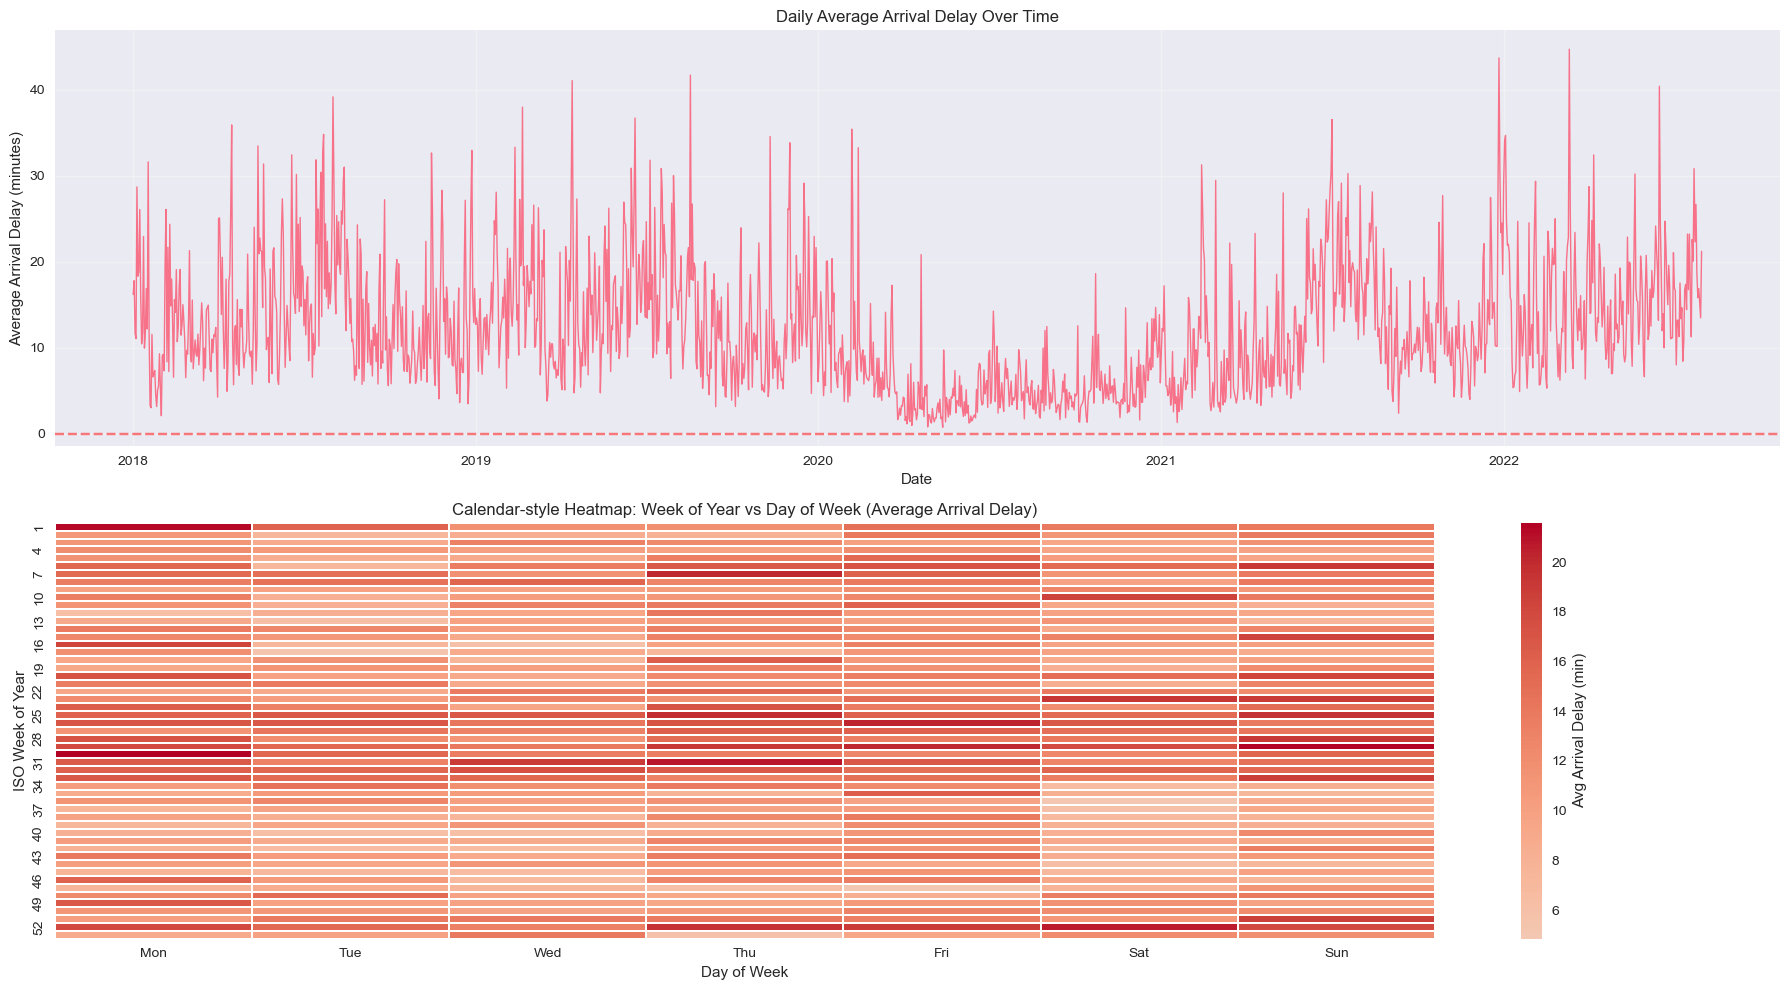

In [21]:
# Time-series and calendar-style heatmap of average arrival delay

fig, axes = plt.subplots(2, 1, figsize=(18, 10))

# 1) Time series of daily average arrival delay
axes[0].plot(daily_delay['FlightDate'], daily_delay['avg_arr_delay'], linewidth=1.0)
axes[0].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[0].set_title('Daily Average Arrival Delay Over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Average Arrival Delay (minutes)')
axes[0].grid(alpha=0.3)

# 2) Calendar-style heatmap: week of year vs day of week (aggregated across years)
cal_data = daily_delay.copy()
cal_data['dow_short'] = cal_data['FlightDate'].dt.day_name().str.slice(0, 3)

# Pivot: rows = week of year, columns = day of week (short label)
heat_pivot = cal_data.pivot_table(
    index='week_of_year',
    columns='dow_short',
    values='avg_arr_delay',
    aggfunc='mean'
).reindex(columns=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

sns.heatmap(
    heat_pivot,
    ax=axes[1],
    cmap='coolwarm',
    center=0,
    linewidths=0.3,
    linecolor='white',
    cbar_kws={'label': 'Avg Arrival Delay (min)'}
)
axes[1].set_title('Calendar-style Heatmap: Week of Year vs Day of Week (Average Arrival Delay)')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('ISO Week of Year')

plt.tight_layout()
plt.show()


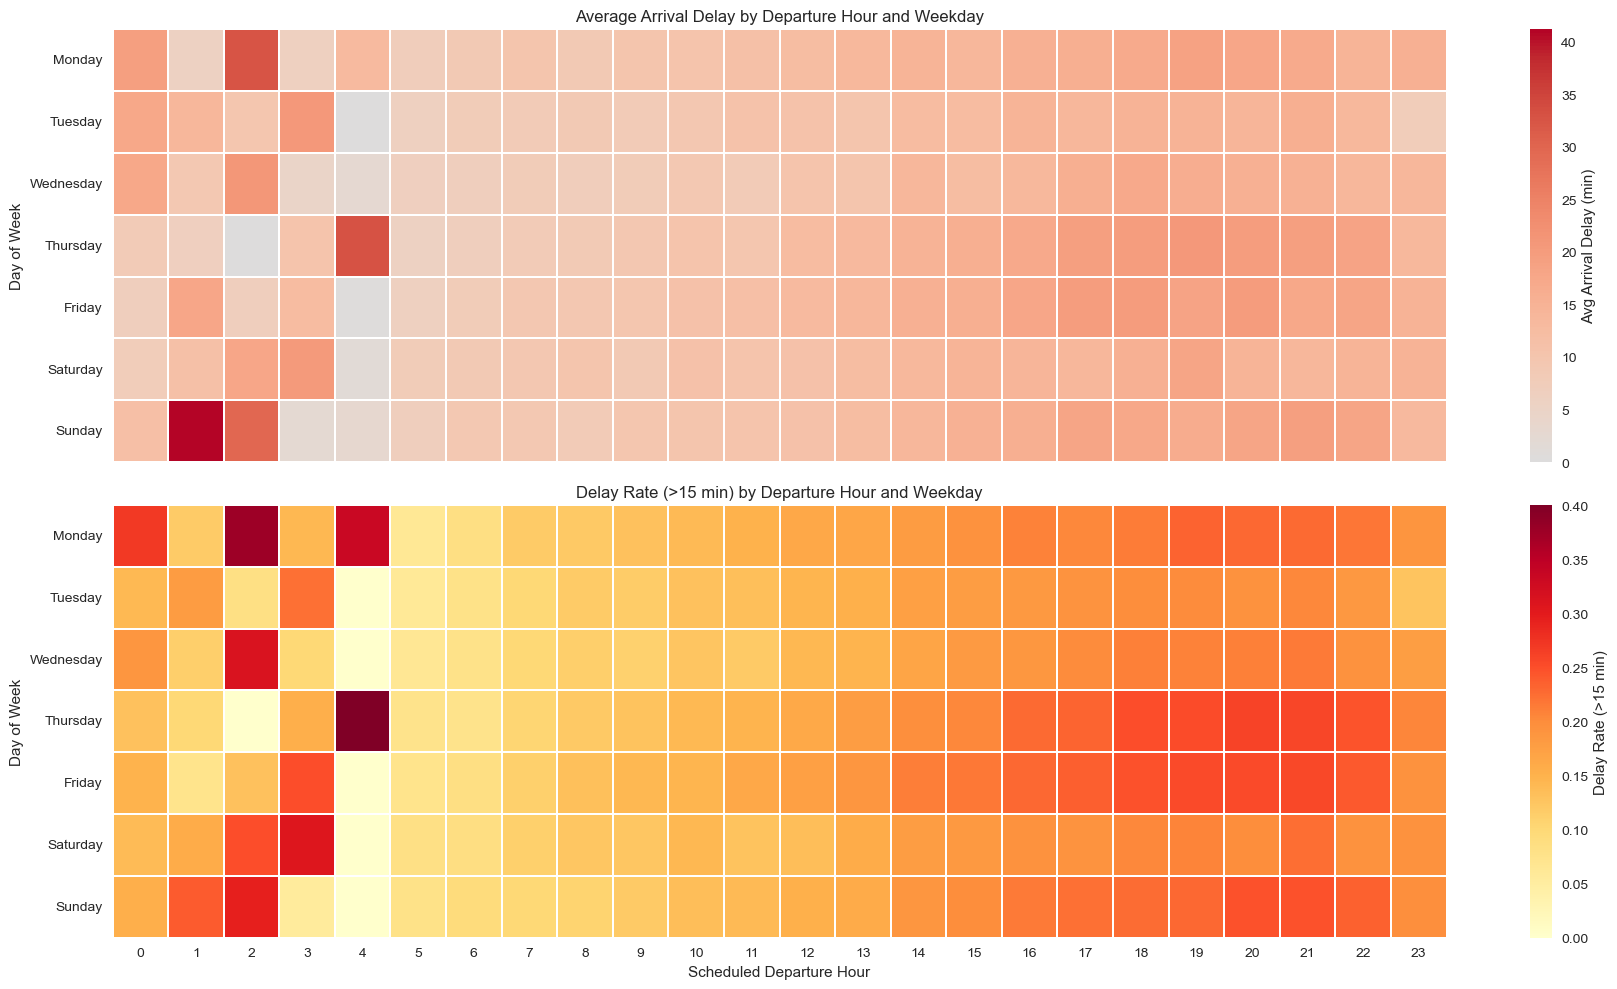

In [22]:
# Heatmaps of average delay and delay rate by departure hour and weekday

# Prepare aggregation at hour x weekday level
hour_weekday = df.copy()

# Ensure DepHour exists (created previously), otherwise compute it
if 'DepHour' not in hour_weekday.columns:
    hour_weekday['DepHour'] = (hour_weekday['CRSDepTime'] // 100).astype(int)

hour_weekday['DayOfWeekName'] = hour_weekday['FlightDate'].dt.day_name()

agg_hw = hour_weekday.groupby(['DayOfWeekName', 'DepHour']).agg(
    avg_arr_delay=('ArrDelayMinutes', 'mean'),
    avg_dep_delay=('DepDelayMinutes', 'mean'),
    delay_rate_arr=('ArrDelayMinutes', lambda x: (x > 15).mean()),
    delay_rate_dep=('DepDelayMinutes', lambda x: (x > 15).mean()),
    flights=('ArrDelayMinutes', 'size')
).reset_index()

# Order weekdays
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
agg_hw['DayOfWeekName'] = pd.Categorical(agg_hw['DayOfWeekName'], categories=weekday_order, ordered=True)
agg_hw = agg_hw.sort_values(['DayOfWeekName', 'DepHour'])

# Pivot for heatmaps
pivot_avg = agg_hw.pivot(index='DayOfWeekName', columns='DepHour', values='avg_arr_delay')
pivot_rate = agg_hw.pivot(index='DayOfWeekName', columns='DepHour', values='delay_rate_arr')

fig, axes = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

sns.heatmap(
    pivot_avg,
    ax=axes[0],
    cmap='coolwarm',
    center=0,
    linewidths=0.3,
    linecolor='white',
    cbar_kws={'label': 'Avg Arrival Delay (min)'}
)
axes[0].set_title('Average Arrival Delay by Departure Hour and Weekday')
axes[0].set_xlabel('')
axes[0].set_ylabel('Day of Week')

sns.heatmap(
    pivot_rate,
    ax=axes[1],
    cmap='YlOrRd',
    vmin=0,
    vmax=pivot_rate.max().max(),
    linewidths=0.3,
    linecolor='white',
    cbar_kws={'label': 'Delay Rate (>15 min)'}
)
axes[1].set_title('Delay Rate (>15 min) by Departure Hour and Weekday')
axes[1].set_xlabel('Scheduled Departure Hour')
axes[1].set_ylabel('Day of Week')

plt.tight_layout()
plt.show()


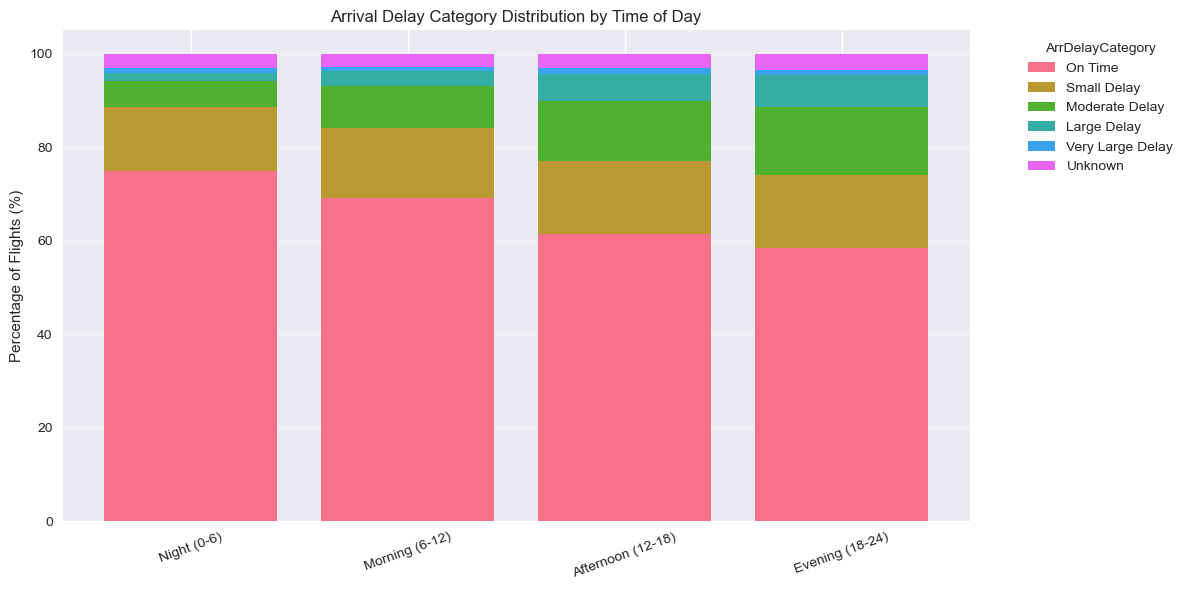

In [23]:
# Cohort comparison: delay category distribution by time-of-day

# Reuse existing delay categories and DepTimeOfDay
cohort_tod = df.copy()

# Ensure ArrDelayCategory exists; if not, recompute quickly
if 'ArrDelayCategory' not in cohort_tod.columns:
    def categorize_delay(delay_minutes):
        if pd.isna(delay_minutes):
            return 'Unknown'
        elif delay_minutes < 0:
            return 'Early'
        elif delay_minutes == 0:
            return 'On Time'
        elif delay_minutes <= 15:
            return 'Small Delay'
        elif delay_minutes <= 60:
            return 'Moderate Delay'
        elif delay_minutes <= 180:
            return 'Large Delay'
        else:
            return 'Very Large Delay'
    cohort_tod['ArrDelayCategory'] = cohort_tod['ArrDelayMinutes'].apply(categorize_delay)

if 'DepTimeOfDay' not in cohort_tod.columns:
    cohort_tod['DepHour'] = (cohort_tod['CRSDepTime'] // 100).astype(int)
    cohort_tod['DepTimeOfDay'] = pd.cut(
        cohort_tod['DepHour'],
        bins=[0, 6, 12, 18, 24],
        labels=['Night (0-6)', 'Morning (6-12)', 'Afternoon (12-18)', 'Evening (18-24)'],
        include_lowest=True
    )

category_order = ['Early', 'On Time', 'Small Delay', 'Moderate Delay', 'Large Delay', 'Very Large Delay', 'Unknown']

tod_cat = (
    cohort_tod
    .groupby(['DepTimeOfDay', 'ArrDelayCategory'])['ArrDelayMinutes']
    .size()
    .reset_index(name='count')
)

# Normalize to percentages within each time-of-day cohort
tod_totals = tod_cat.groupby('DepTimeOfDay')['count'].transform('sum')
tod_cat['perc'] = tod_cat['count'] / tod_totals * 100

# Pivot to stacked-bar friendly format
pivot_tod = tod_cat.pivot(index='DepTimeOfDay', columns='ArrDelayCategory', values='perc')
pivot_tod = pivot_tod[[c for c in category_order if c in pivot_tod.columns]]

fig, ax = plt.subplots(figsize=(12, 6))

bottom = np.zeros(len(pivot_tod))
for cat in pivot_tod.columns:
    values = pivot_tod[cat].fillna(0).values
    ax.bar(pivot_tod.index.astype(str), values, bottom=bottom, label=cat)
    bottom += values

ax.set_ylabel('Percentage of Flights (%)')
ax.set_title('Arrival Delay Category Distribution by Time of Day')
ax.legend(title='ArrDelayCategory', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


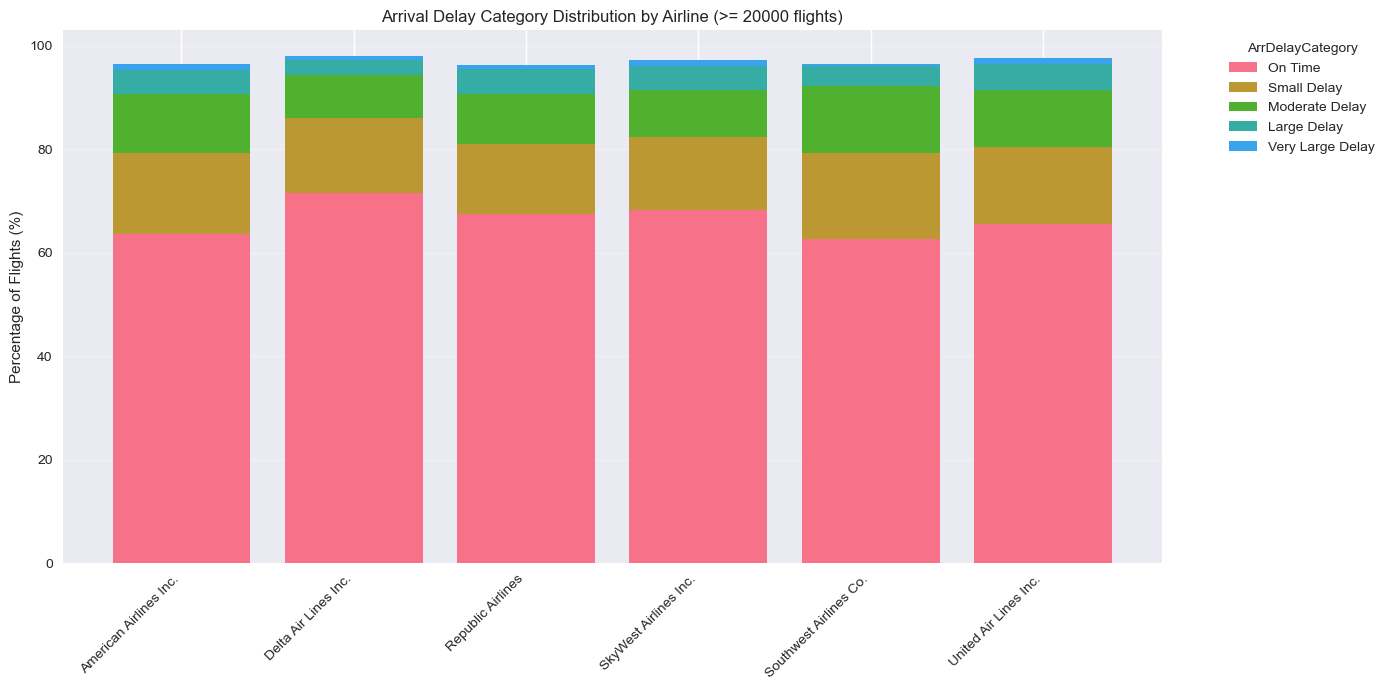

In [24]:
# Cohort comparison: delay category distribution by airline (top N)

# Focus on airlines with substantial traffic to keep the visualization clean
min_flights_per_airline = 20000

cohort_airline = df.copy()

# Ensure ArrDelayCategory exists
if 'ArrDelayCategory' not in cohort_airline.columns:
    def categorize_delay(delay_minutes):
        if pd.isna(delay_minutes):
            return 'Unknown'
        elif delay_minutes < 0:
            return 'Early'
        elif delay_minutes == 0:
            return 'On Time'
        elif delay_minutes <= 15:
            return 'Small Delay'
        elif delay_minutes <= 60:
            return 'Moderate Delay'
        elif delay_minutes <= 180:
            return 'Large Delay'
        else:
            return 'Very Large Delay'
    cohort_airline['ArrDelayCategory'] = cohort_airline['ArrDelayMinutes'].apply(categorize_delay)

airline_counts = cohort_airline['Airline'].value_counts()
top_airlines = airline_counts[airline_counts >= min_flights_per_airline].index.tolist()

cohort_airline = cohort_airline[cohort_airline['Airline'].isin(top_airlines)]

airline_cat = (
    cohort_airline
    .groupby(['Airline', 'ArrDelayCategory'])['ArrDelayMinutes']
    .size()
    .reset_index(name='count')
)

airline_totals = airline_cat.groupby('Airline')['count'].transform('sum')
airline_cat['perc'] = airline_cat['count'] / airline_totals * 100

# Pivot for stacked bars
pivot_airline = airline_cat.pivot(index='Airline', columns='ArrDelayCategory', values='perc')
pivot_airline = pivot_airline[[c for c in ['Early', 'On Time', 'Small Delay', 'Moderate Delay', 'Large Delay', 'Very Large Delay'] if c in pivot_airline.columns]]

fig, ax = plt.subplots(figsize=(14, 7))

bottom = np.zeros(len(pivot_airline))
for cat in pivot_airline.columns:
    values = pivot_airline[cat].fillna(0).values
    ax.bar(pivot_airline.index.astype(str), values, bottom=bottom, label=cat)
    bottom += values

ax.set_ylabel('Percentage of Flights (%)')
ax.set_title(f'Arrival Delay Category Distribution by Airline (>= {min_flights_per_airline} flights)')
ax.legend(title='ArrDelayCategory', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
